# Introduction

Our goal is to create a model that can predict if a URL is malicious (phishing, malware, etc) or benign. As a large portion of our lives are digitalized (banking information, social circles, etc), it is imperative that we have robust personal digital security. The ramifications of clicking on malicious links are great in magnitude -- you could get your bank account hacked or sensitive information stolen. We can take a more defensive approach to this, and predict whether or not a link is malicious before clicking on certain links.

The dataset we have chosen has 6728848 records total with 59 features each. Because of the magnitude of the number of features, we will have to employ feature selection and dimensionality reduction to avoid the curse of dimensionality.

The features describe the URL through numerically and categorically breaking down the URL into relevant numbers and strings. As an example, we have listed some of the features below.

*url_has_login*: If the URL has 'login' string.

*url_entropy*: Entropy of the characters in the URL.

*path_len*: Length of the path portion of the URL.

The label is 1 if the URL is malicious and the label is 0 if the URL is benign.

# Data Cleaning and Exploration

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.datasets import make_blobs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

#### Read in the data and display the head.

In [2]:
url_data = pd.read_csv('train_dataset.csv')
url_data.head()

,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0


#### Drop duplicate values.

There are none! :D

In [3]:
print("Number of records before dropping duplicates:", len(url_data))
url_data.drop_duplicates(inplace=True)
print("Number of records after dropping duplicates:", len(url_data))

Number of records before dropping duplicates: 6728848
Number of records after dropping duplicates: 6728848


#### Check the dataset for missing values.

There are none! :D

In [4]:
url_data.isnull().sum()

url                                    0
label                                  0
source                                 0
url_has_login                          0
url_has_client                         0
url_has_server                         0
url_has_admin                          0
url_has_ip                             0
url_isshorted                          0
url_len                                0
url_entropy                            0
url_hamming_1                          0
url_hamming_00                         0
url_hamming_10                         0
url_hamming_01                         0
url_hamming_11                         0
url_2bentropy                          0
url_3bentropy                          0
url_count_dot                          0
url_count_https                        0
url_count_http                         0
url_count_perc                         0
url_count_hyphen                       0
url_count_www                          0
url_count_atrate

#### Check for a class imbalance.

There are 1445673 malicious URLS (label = 1) and 5283175 benign URLS (label = 0). 27.36% of the data are positive. 
Because the cost of a false negative is greater than the cost of a false positive, clicking on a malicious URL for the former and not clicking on a benign URL for the latter, we will prioritize detection of malicious URLs. Thus, inside of the cross validation loop, we will employ oversampling of the minority class. 

We will use SMOTE (Synthetic Minority Oversampling Technique) to oversample from the minority class. This ensures that our model has enough examples of the rarer class to learn how to identify the rarer class. This oversampling will be done inside the cross validation loop to prevent data leakage (we only want to use training data to generate new datapoints).

In [5]:
print("Pre-oversampling label distribution:")
url_data['label'].value_counts()

Pre-oversampling label distribution:


label
0    5283175
1    1445673
Name: count, dtype: int64

#### Visualize the feature values.
Plot all of the nonbinary numerical features as a histogram.

Note how a lot of features have a skewed distribution, where most of the values are concentrated around a central value with a scattering of very extreme outliers.

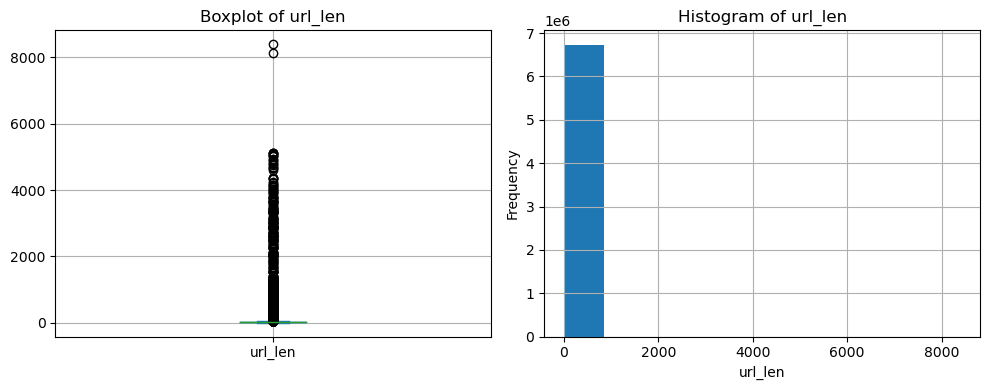

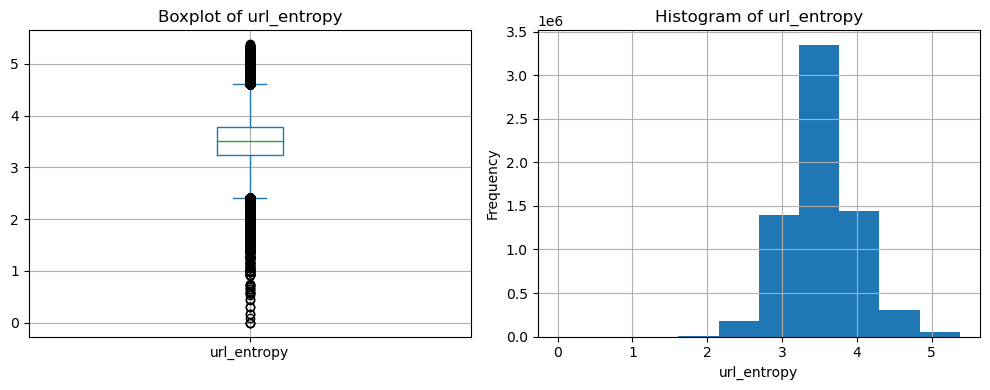

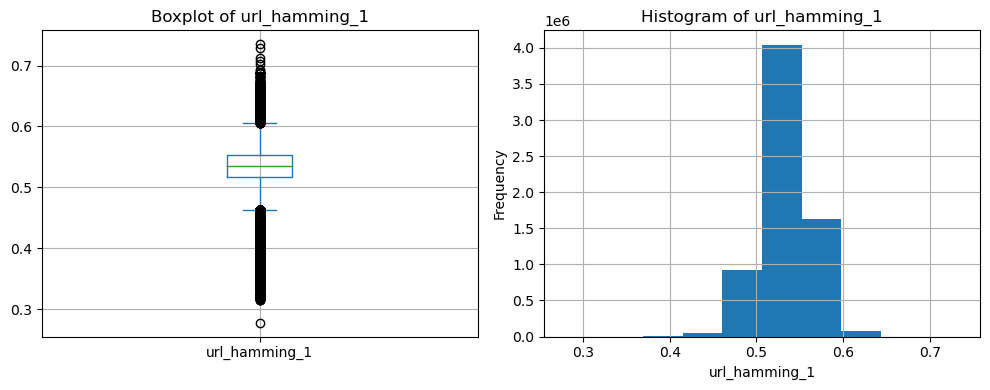

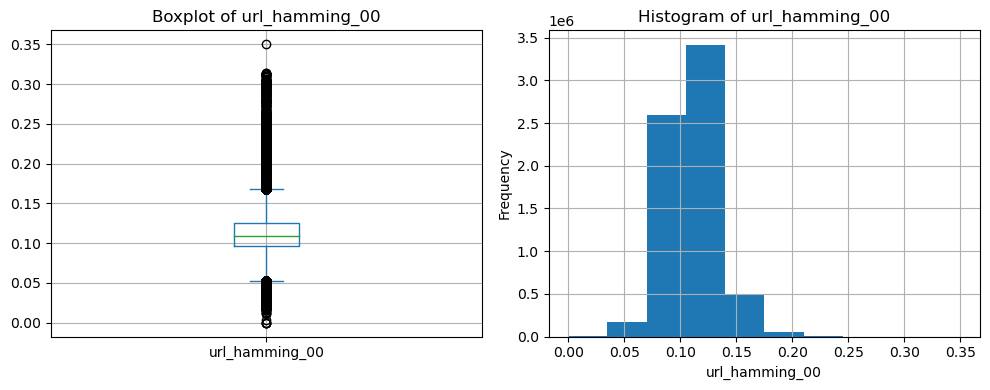

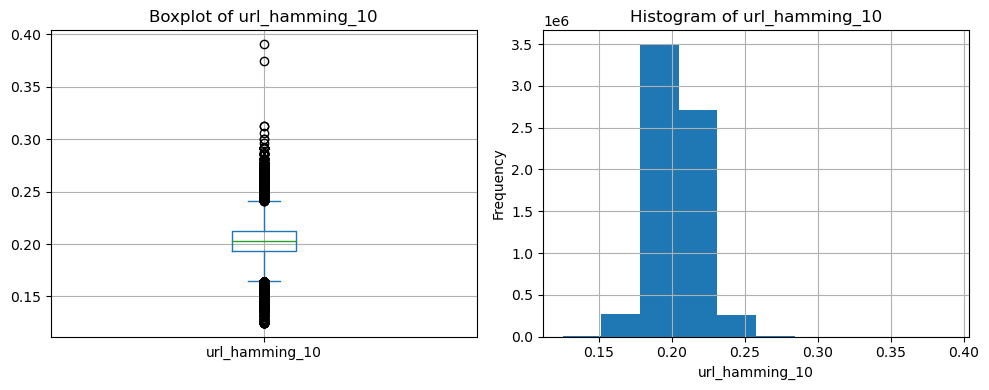

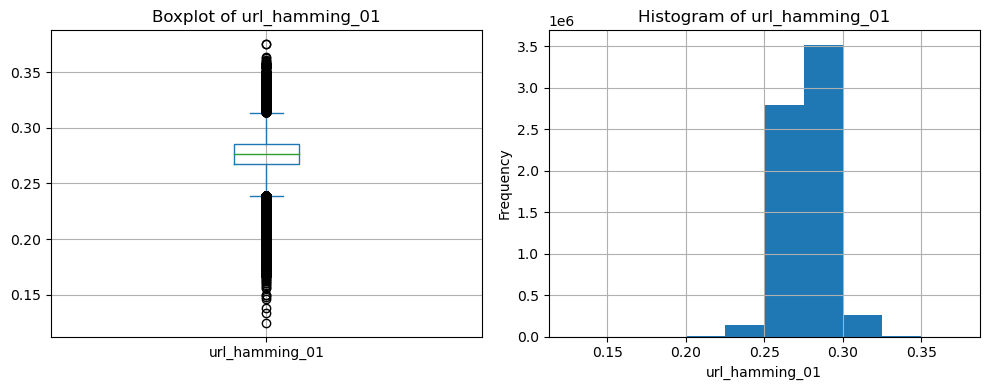

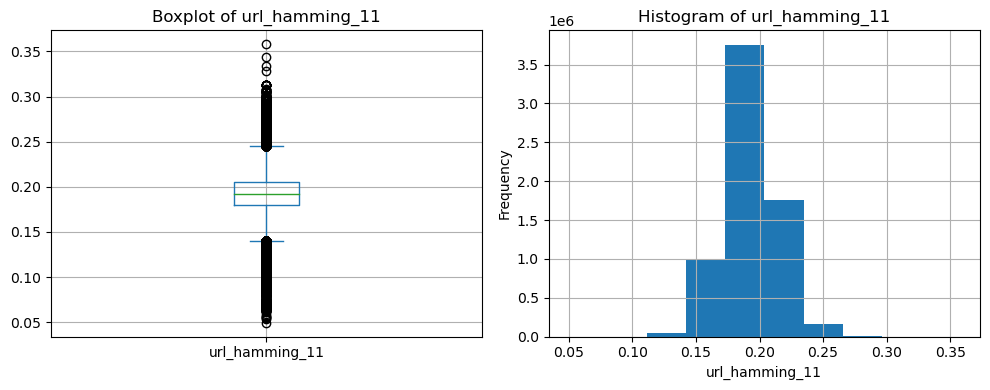

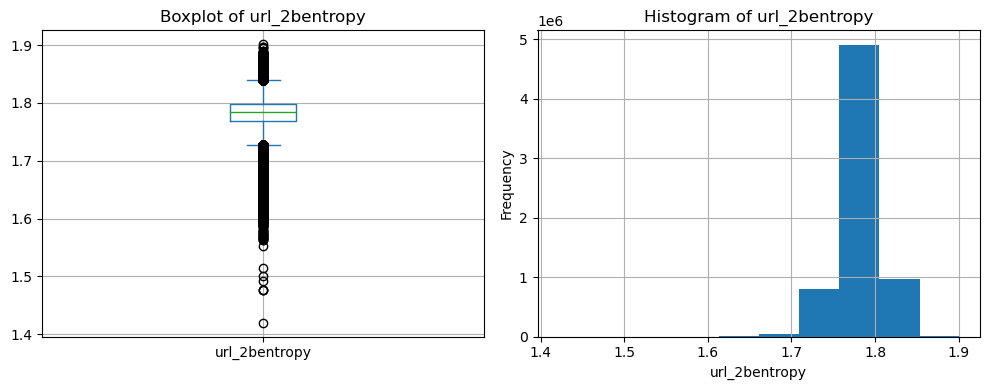

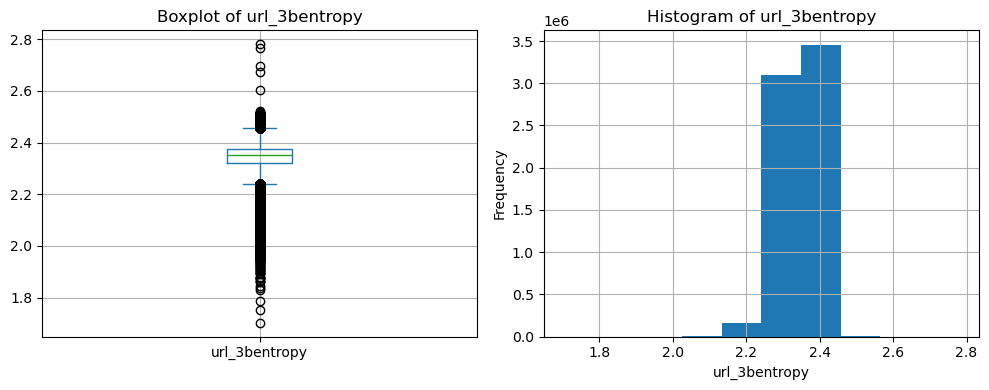

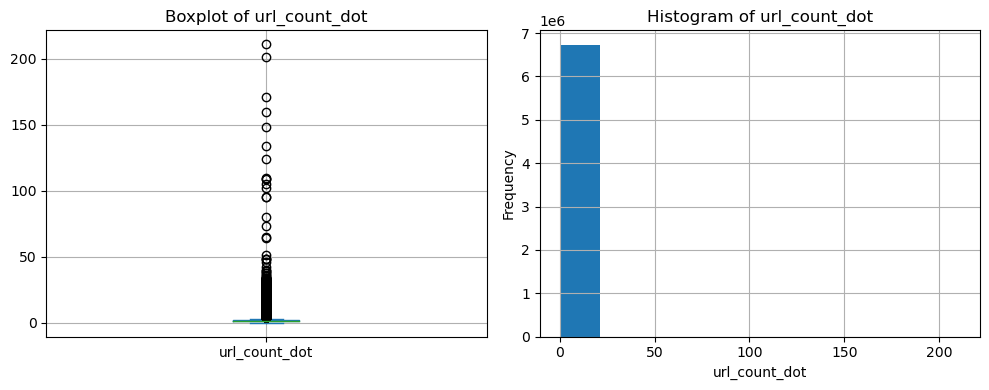

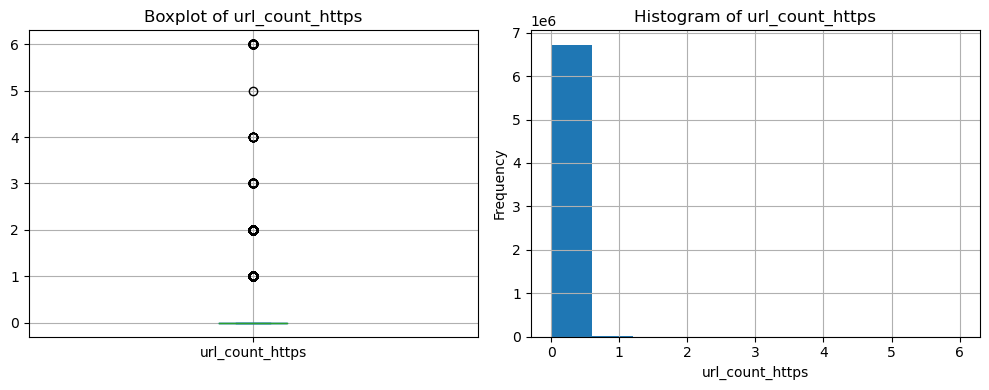

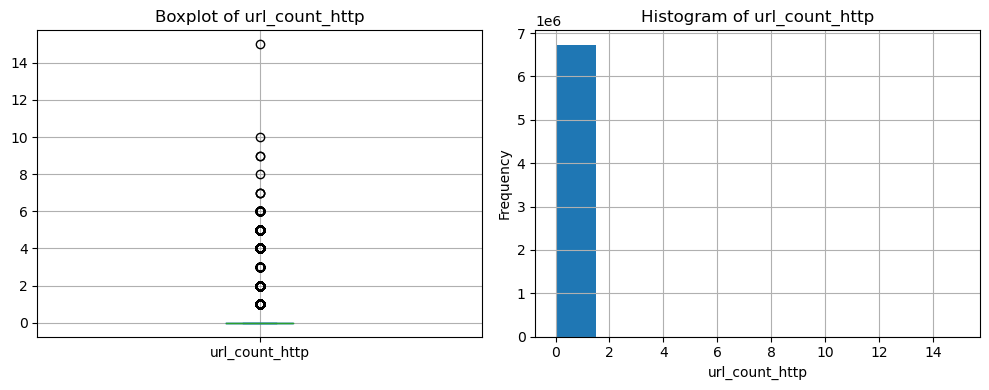

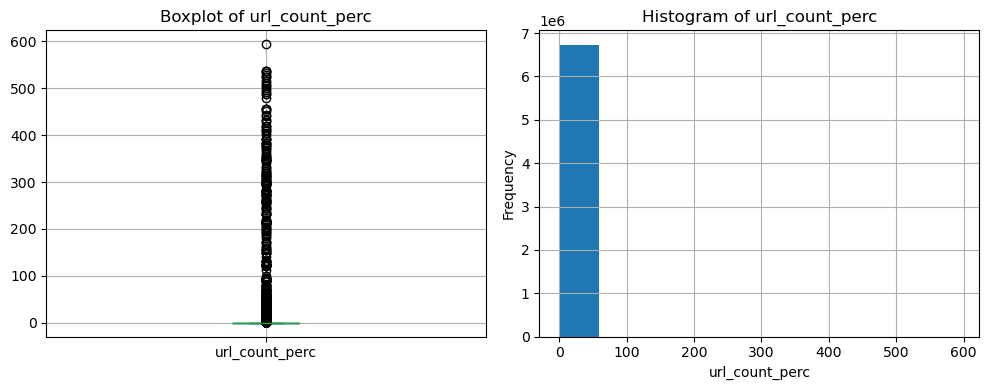

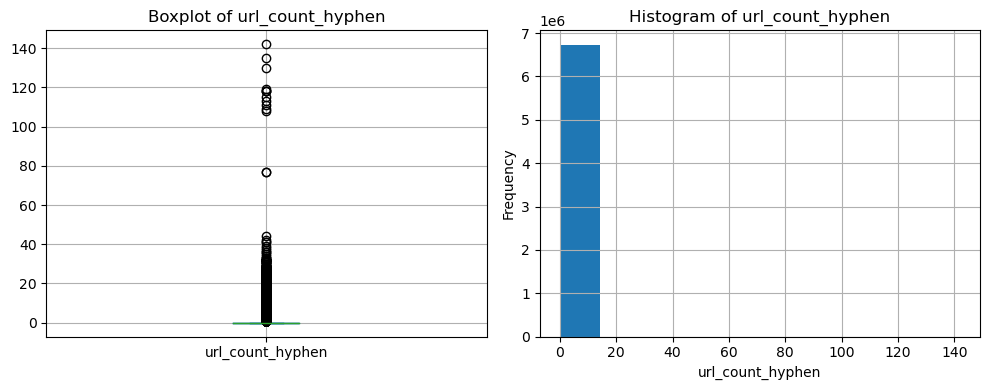

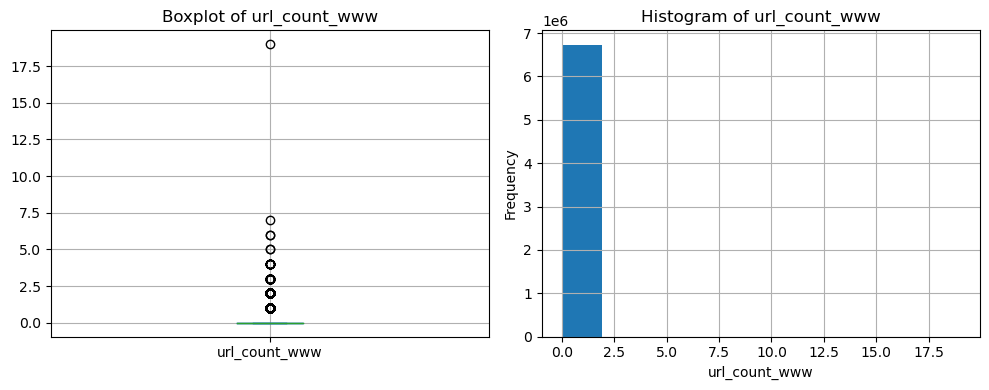

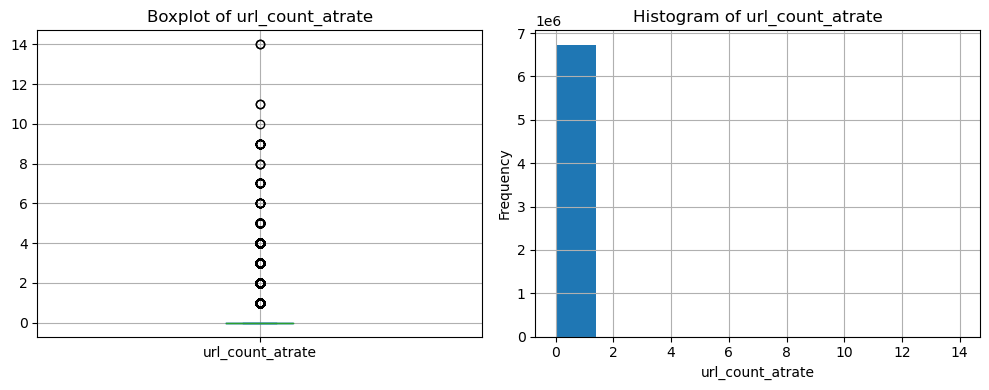

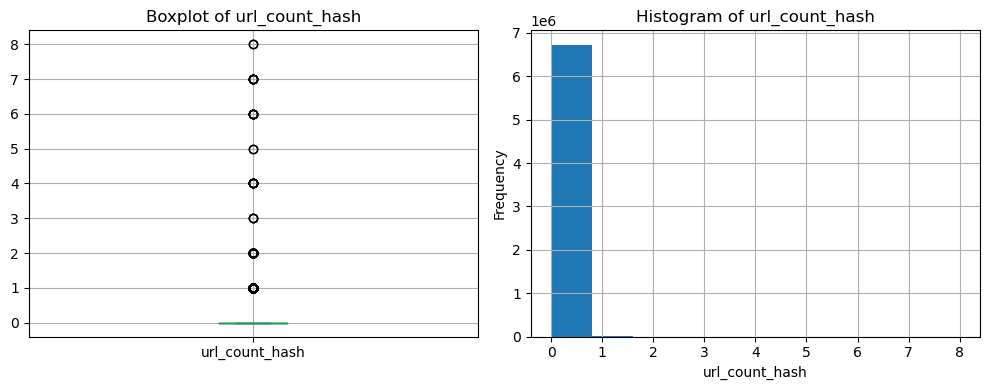

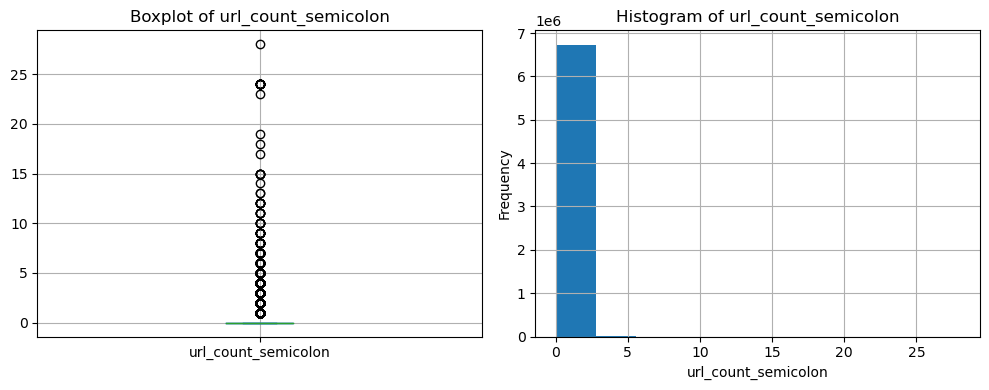

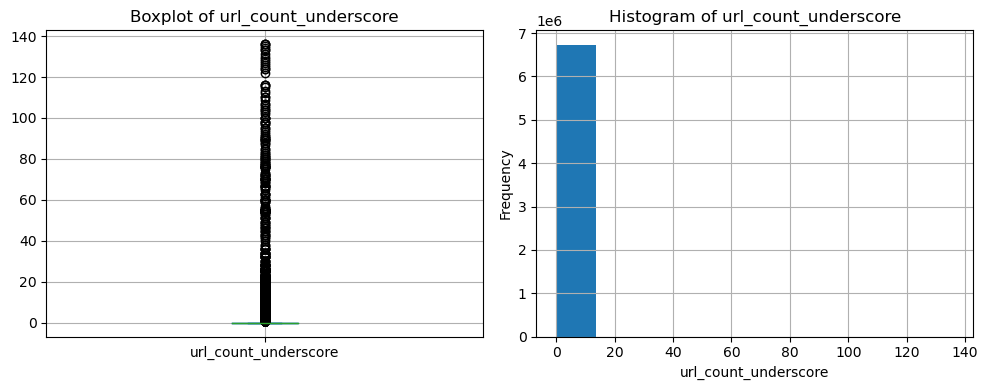

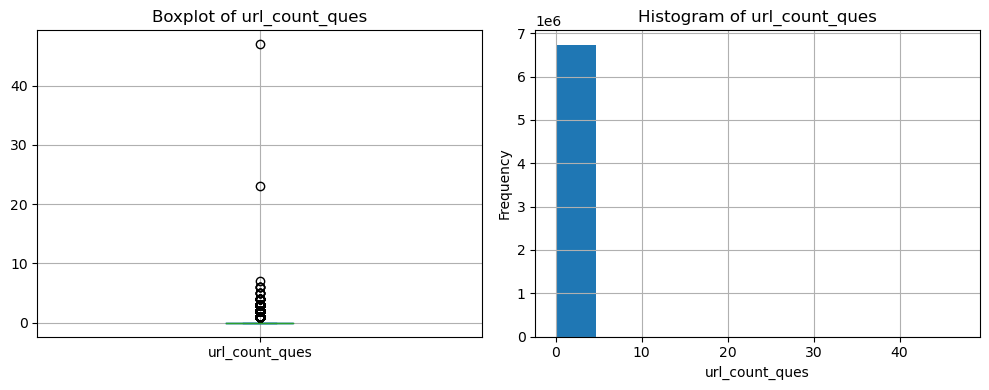

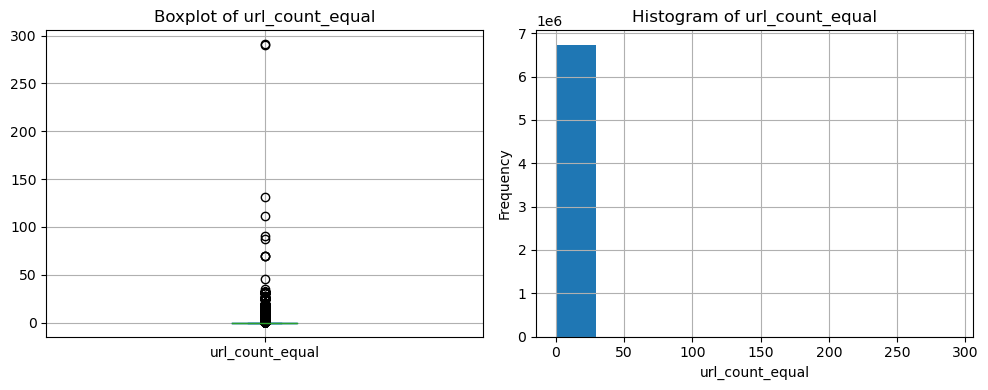

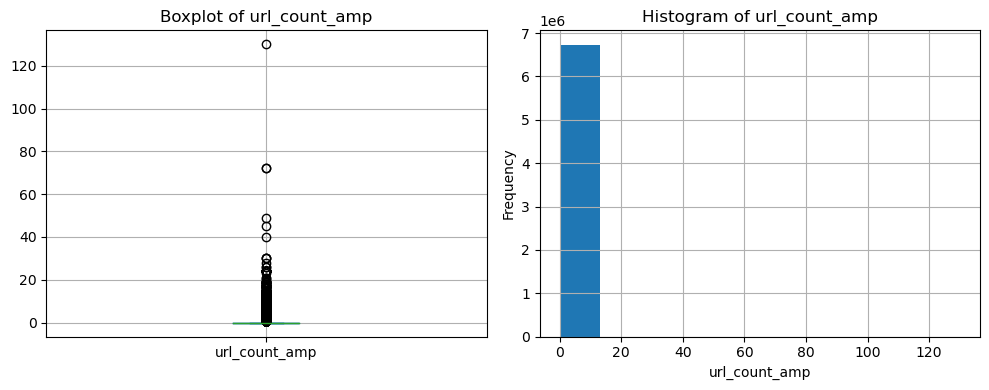

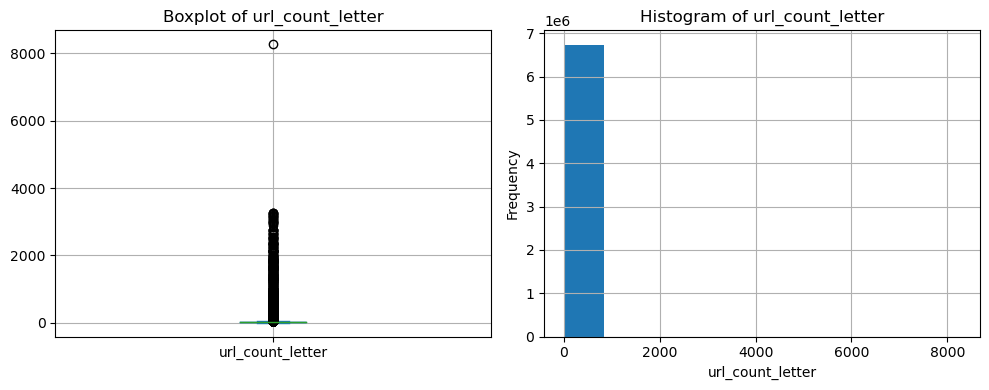

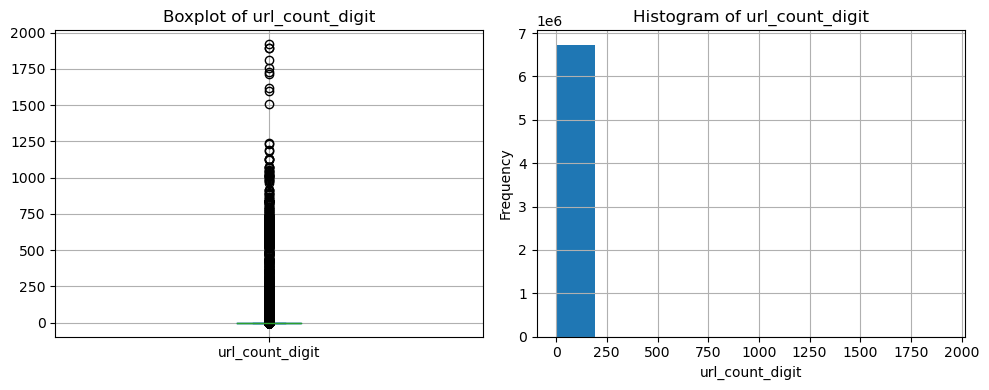

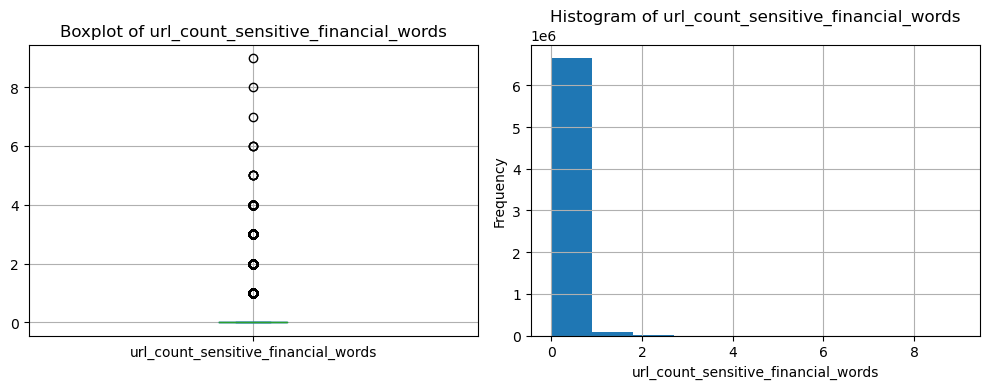

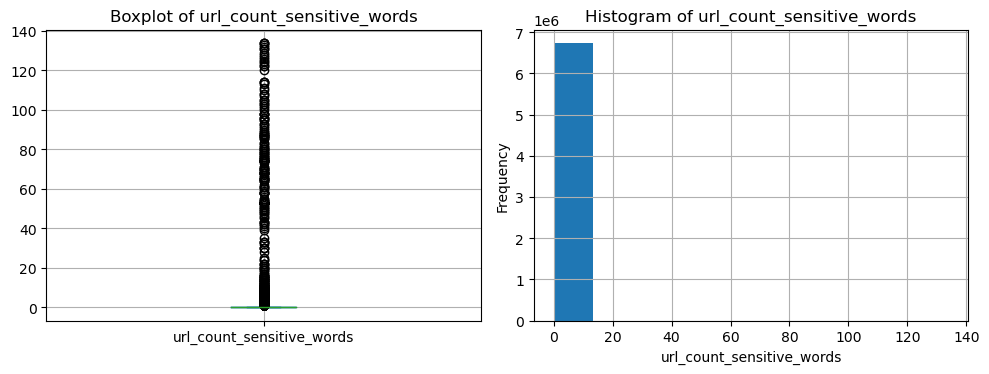

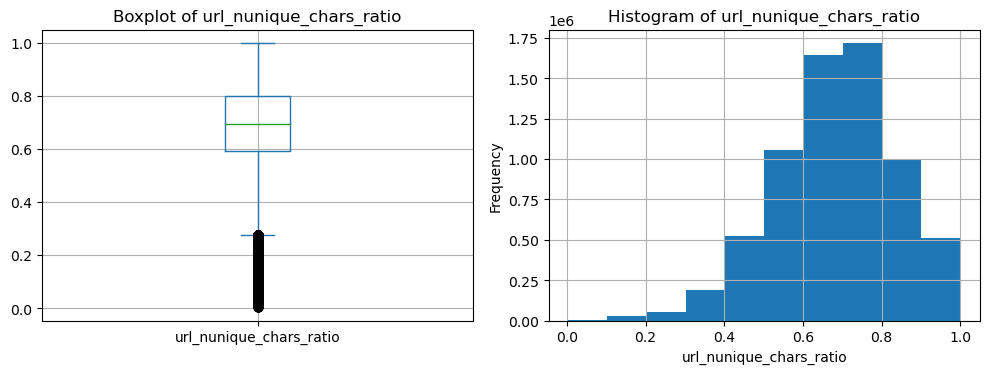

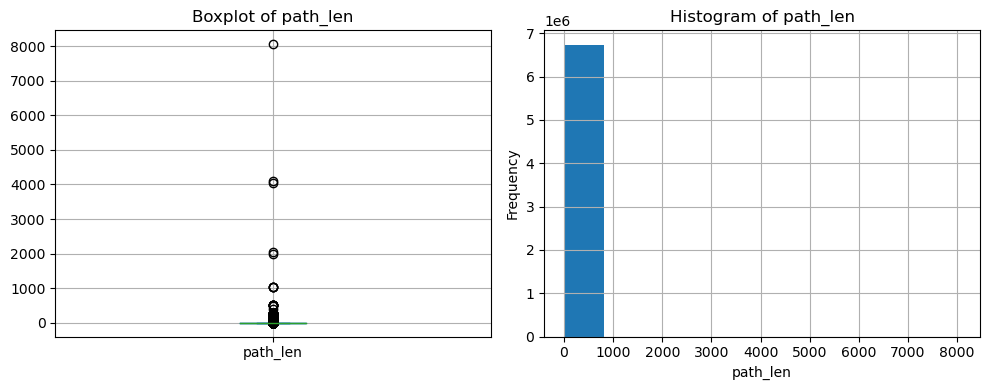

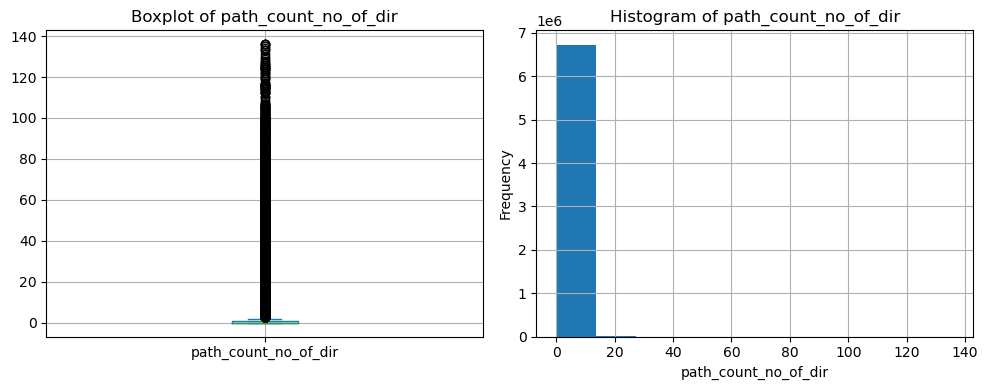

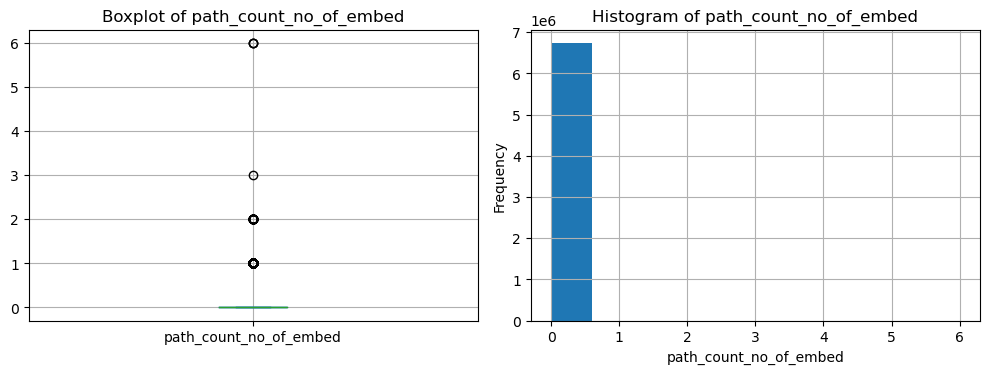

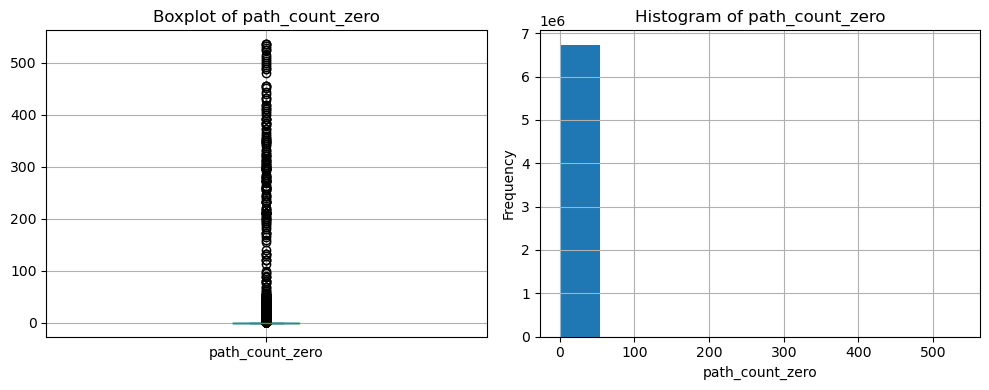

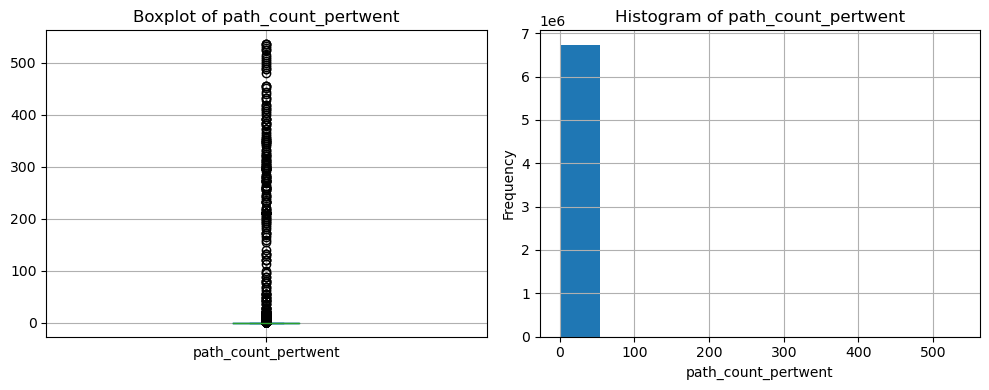

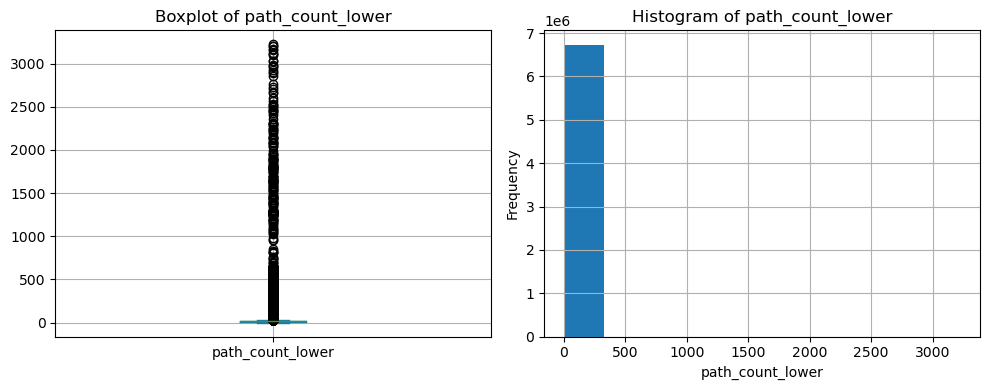

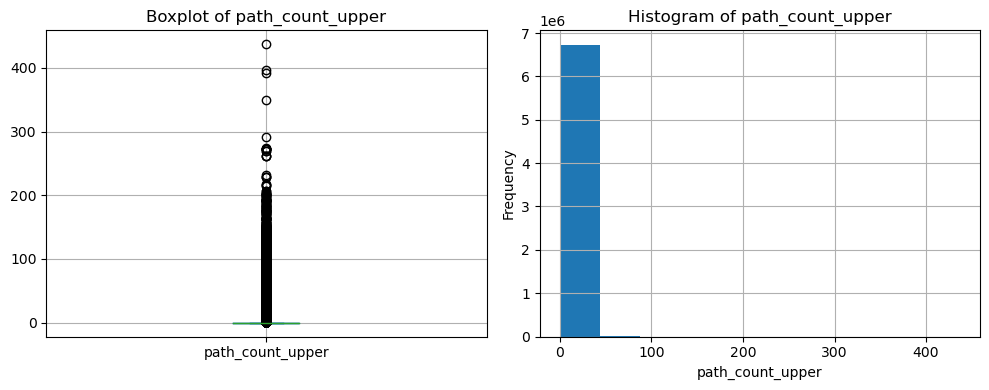

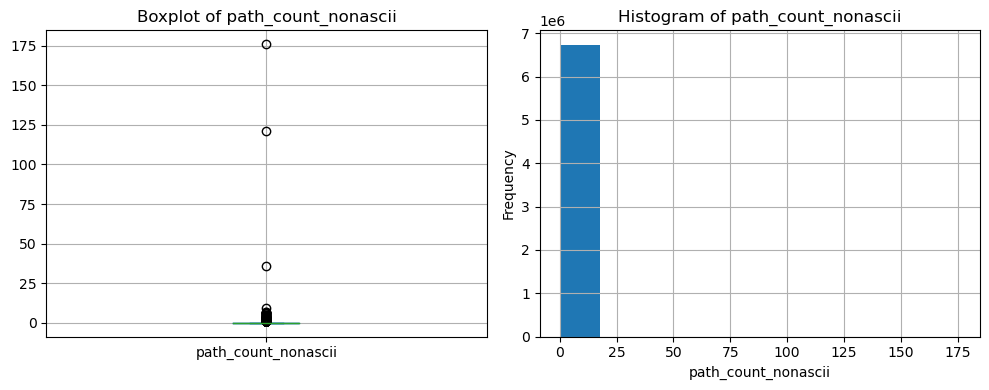

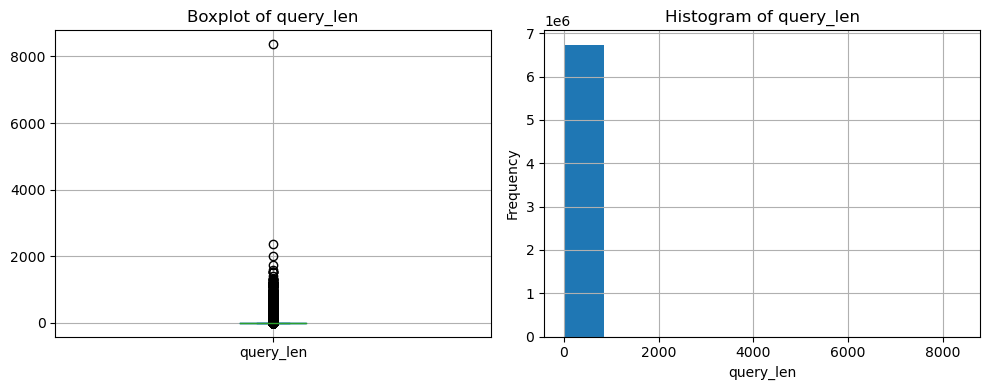

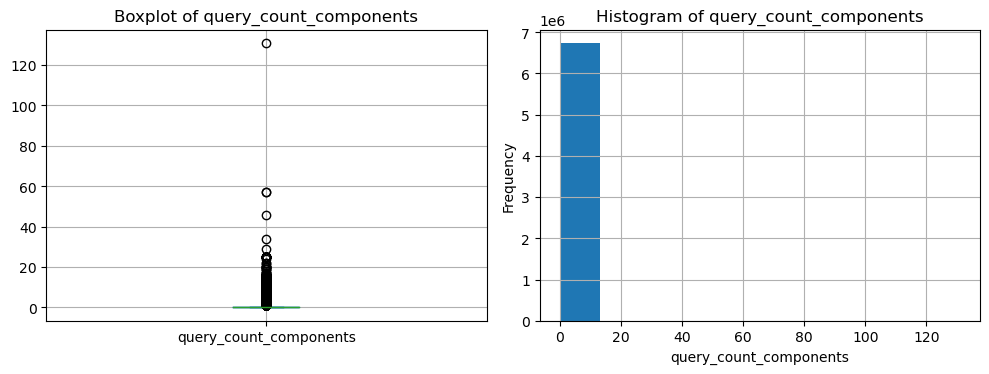

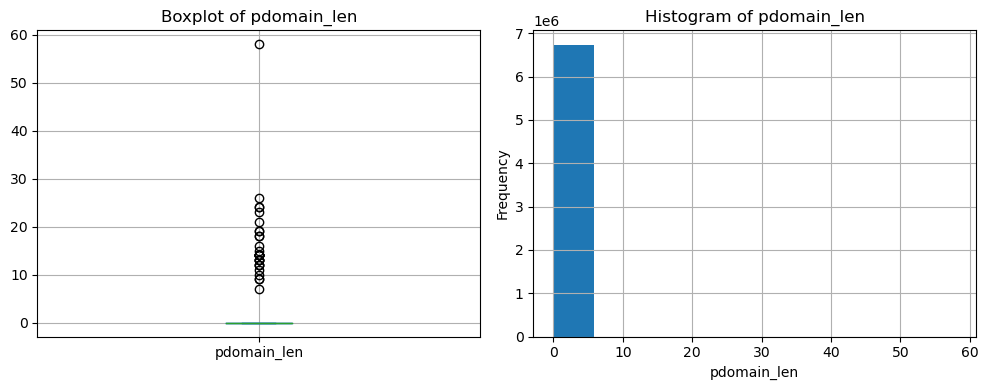

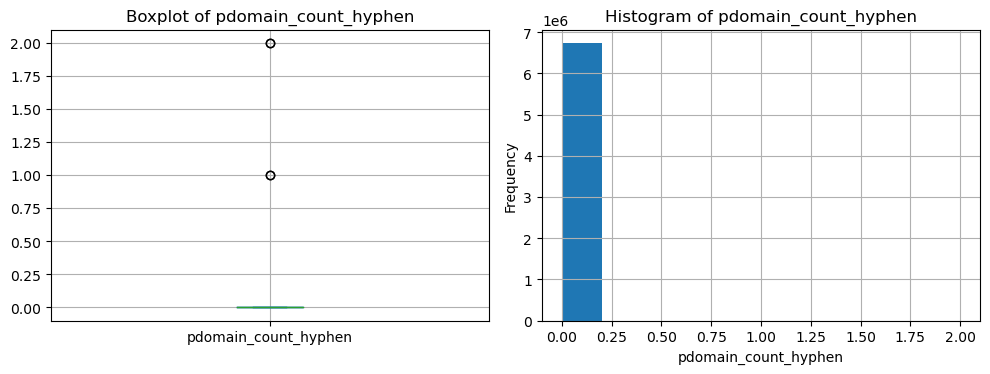

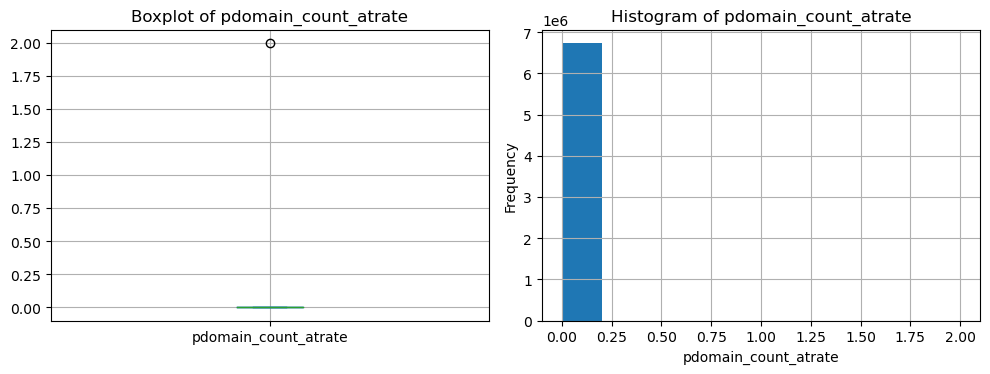

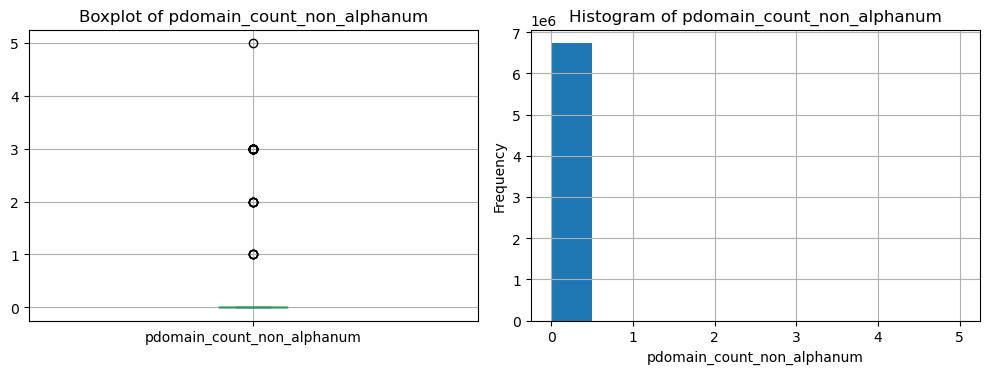

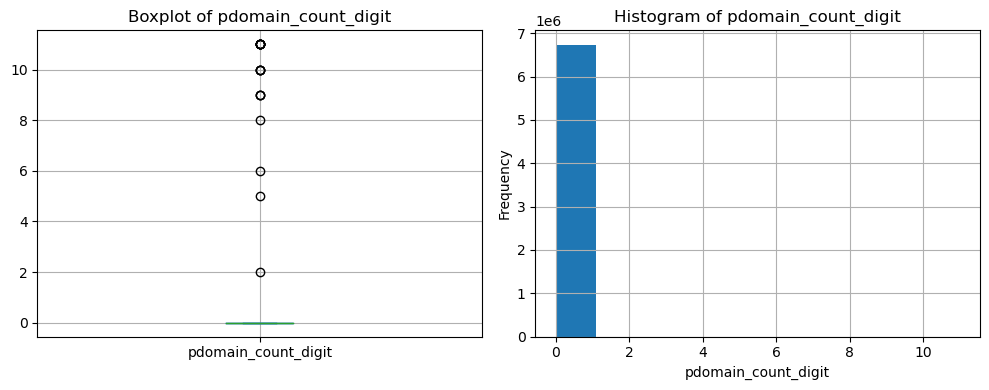

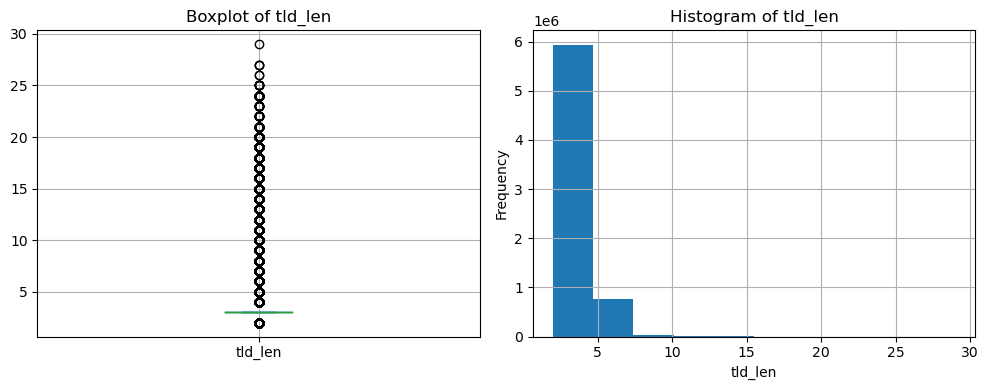

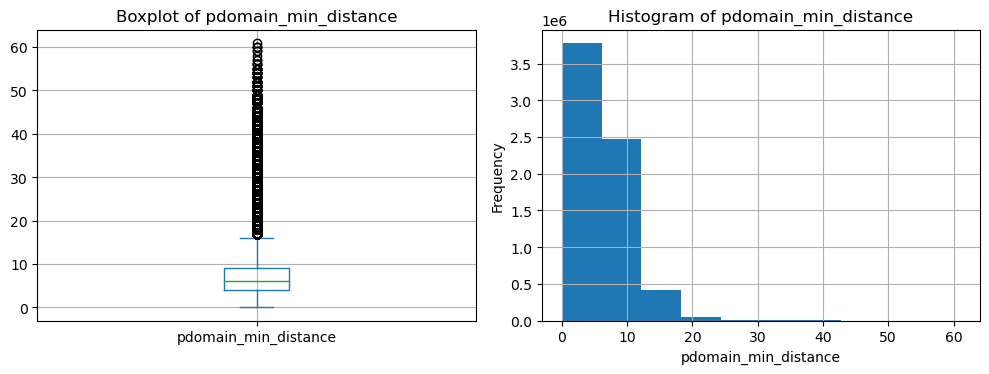

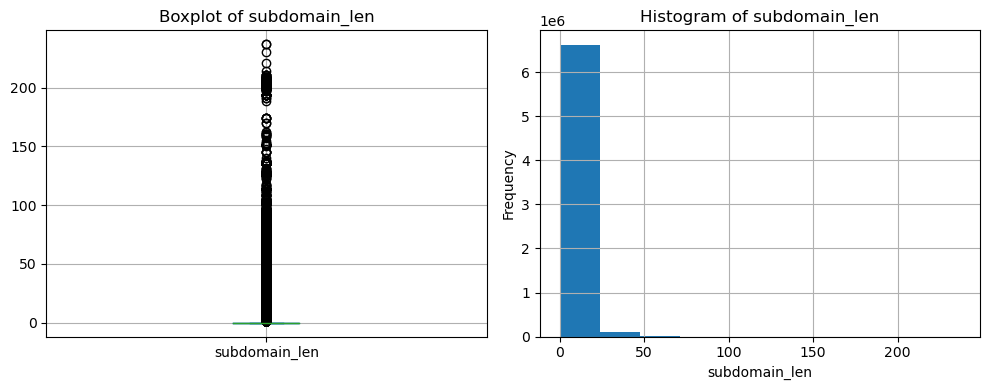

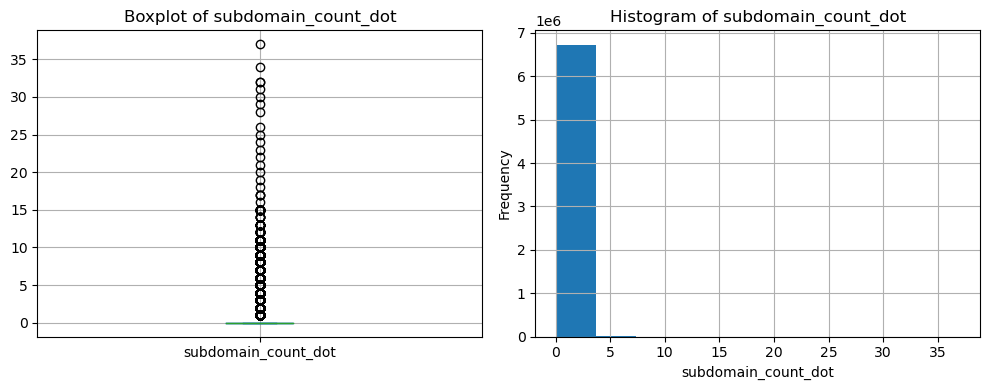

In [6]:
# Only handle numeric, nonbinary features
num_nonbin_features = ["url_len", "url_entropy", "url_hamming_1", "url_hamming_00", "url_hamming_10", 
                       "url_hamming_01", "url_hamming_11", "url_2bentropy", "url_3bentropy", "url_count_dot",
                       "url_count_https", "url_count_http", "url_count_perc", "url_count_hyphen", "url_count_www",
                       "url_count_atrate", "url_count_hash", "url_count_semicolon", "url_count_underscore",
                       "url_count_ques", "url_count_equal", "url_count_amp", "url_count_letter", "url_count_digit",
                       "url_count_sensitive_financial_words", "url_count_sensitive_words", "url_nunique_chars_ratio",
                       "path_len", "path_count_no_of_dir", "path_count_no_of_embed", "path_count_zero", 
                       "path_count_pertwent", "path_count_lower", "path_count_upper", "path_count_nonascii", 
                       "query_len", "query_count_components", "pdomain_len", "pdomain_count_hyphen", 
                       "pdomain_count_atrate", "pdomain_count_non_alphanum", "pdomain_count_digit", "tld_len",
                       "pdomain_min_distance", "subdomain_len", "subdomain_count_dot"]

for column in num_nonbin_features:
    plt.figure(figsize=(10, 4))
    
    # Create a box plot
    plt.subplot(1, 2, 1)
    url_data[column].plot(kind='box')
    plt.title(f'Boxplot of {column}')
    plt.grid(True)
    
    # Create a histogram
    plt.subplot(1, 2, 2)
    url_data[column].plot(kind='hist')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Check for outliers.
Remove all records with at least one feature value being an outlier, based on a threshold. If a record has at least one feature with a value 2.5 IQRs below Q1 or above Q3, it is an outlier.

Because a lot of our plots show that the distribution of a lot of features are concentrated around a certain value, with some exceptions, we want the threshold to be high (increase from the standard 1.5 IQRs to 2.5 IQRs). If the threshold is too low, all records with values that slightly deviate from the mode will be classified as outliers.

We also replot to show how the distributions have changed. Note how the previous plots are skewed, with the plots showing the central bar (representing the value with the highest frequency) not being centered in the distribution. Removing outliers has fixed the extreme skew (there is still some skew for some features which is to be expected as that is most likely the real world distribution of the feature).

However, there are some features where most of the values are zero and it removed all of the non zero values. We should include these "outliers" as they represent the variation for that feature. Let's remove the outliers again, but exclude the features that have that distribution.

The afformentioned features are:
*url_count_dot, 
url_count_https, 
url_count_http, 
url_count_perc, 
url_count_hyphen, 
url_count_www, 
url_count_atrate, 
url_count_hash, 
url_count_semicolon, 
url_count_underscore, 
url_count_ques, 
url_count_equal, 
url_count_amp, 
url_count_digit, 
url_count_sensitive_financial_words, 
url_count_sensitive_words, 
path_len, 
path_count_no_of_dir, 
path_count_no_of_embed, 
path_count_zero, 
path_count_pertwent, 
path_count_upper, 
path_count_nonascii, 
query_len, 
query_count_components, 
pdomain_len, 
pdomain_count_non_hyphen, 
pdomain_count_non_atrate, 
pdomain_count_non_alphanum, 
pdomain_count_digit, 
subdomain_len, 
subdomain_count_dot*

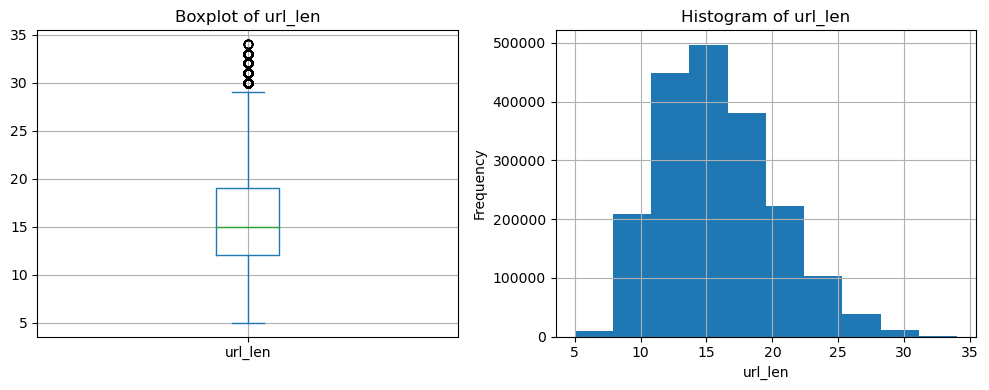

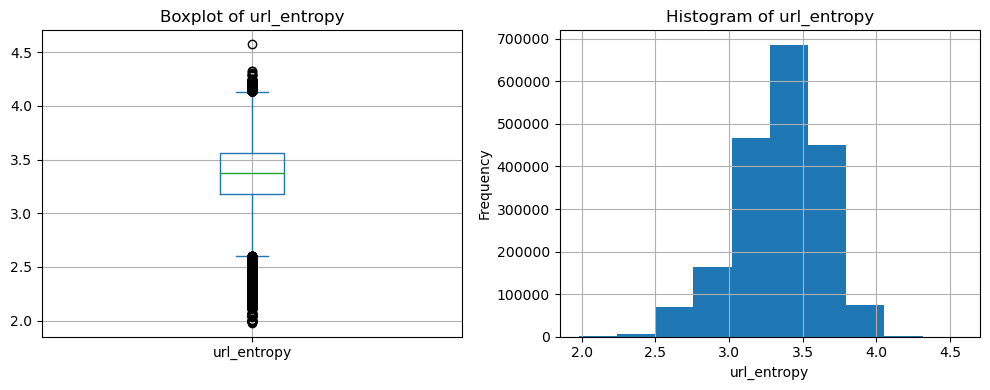

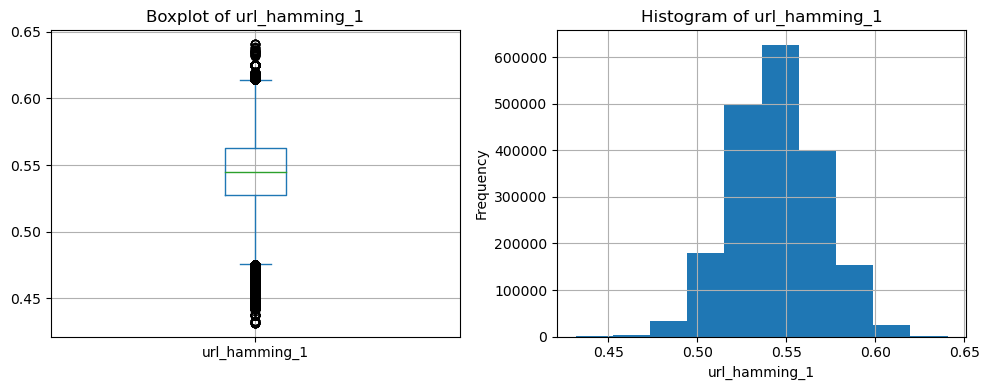

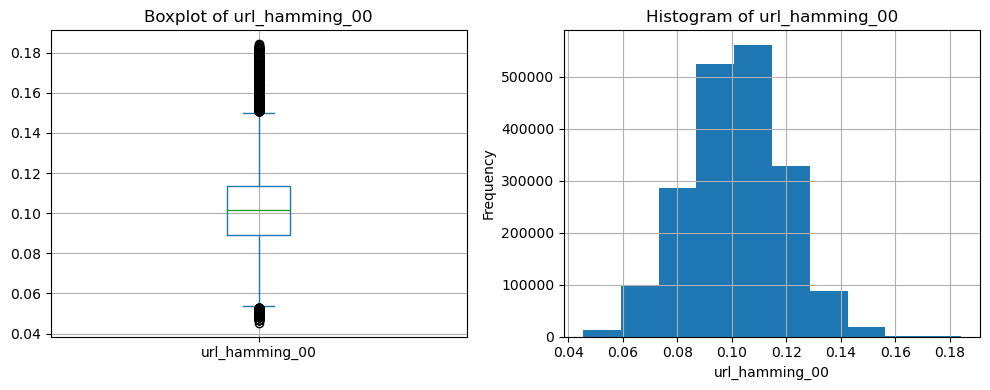

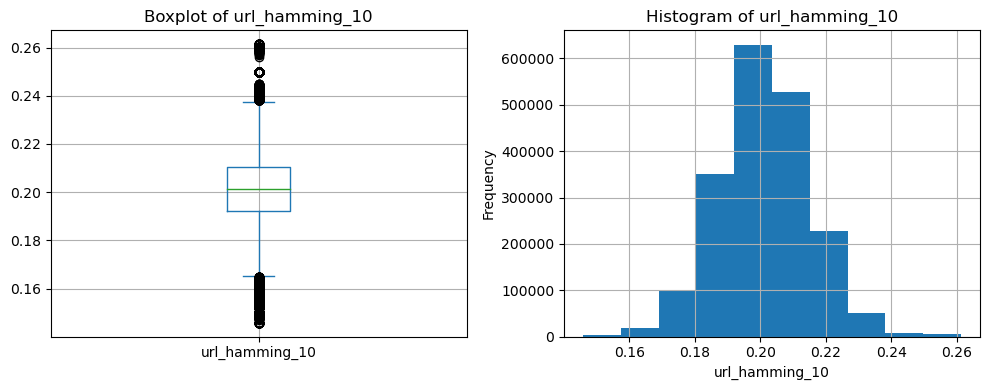

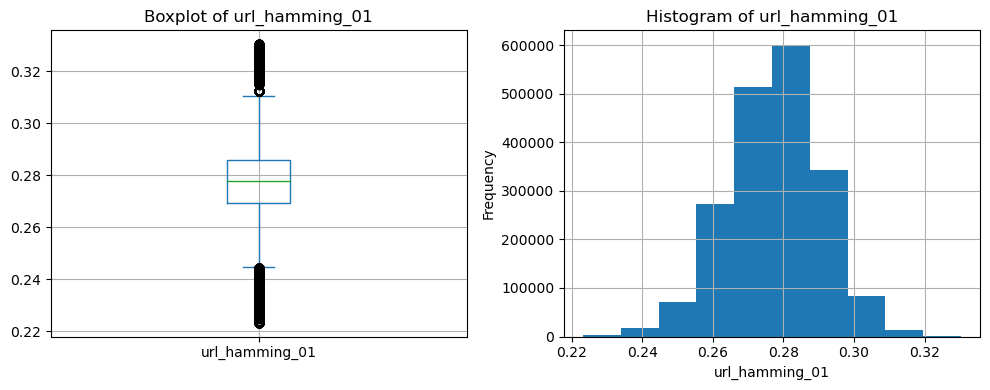

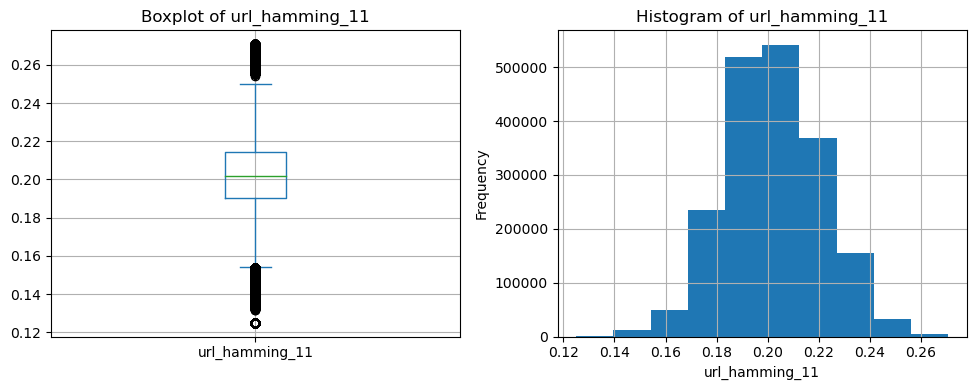

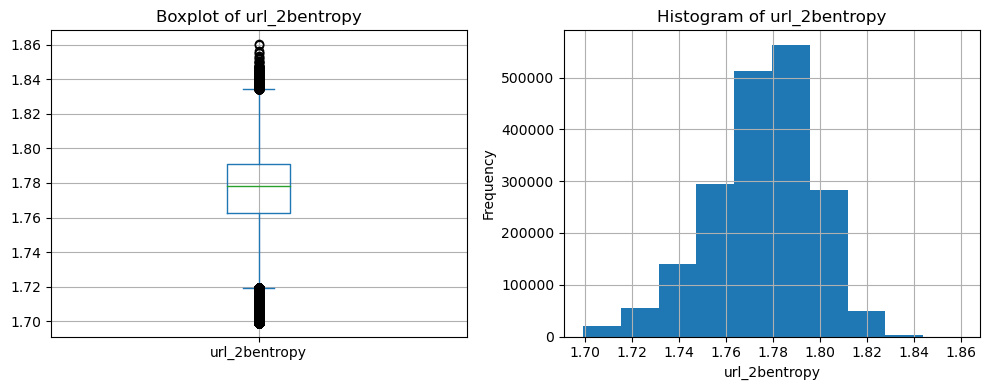

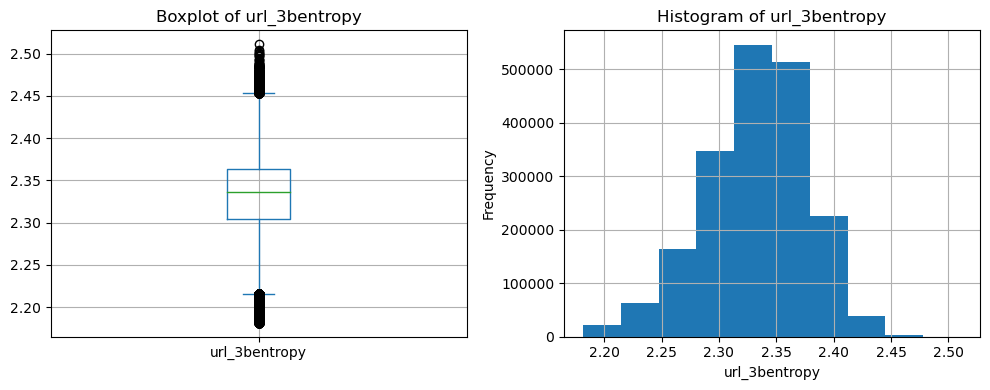

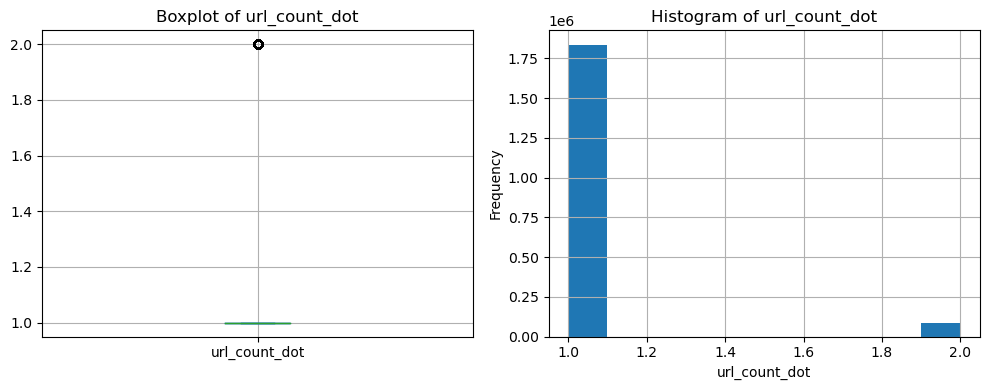

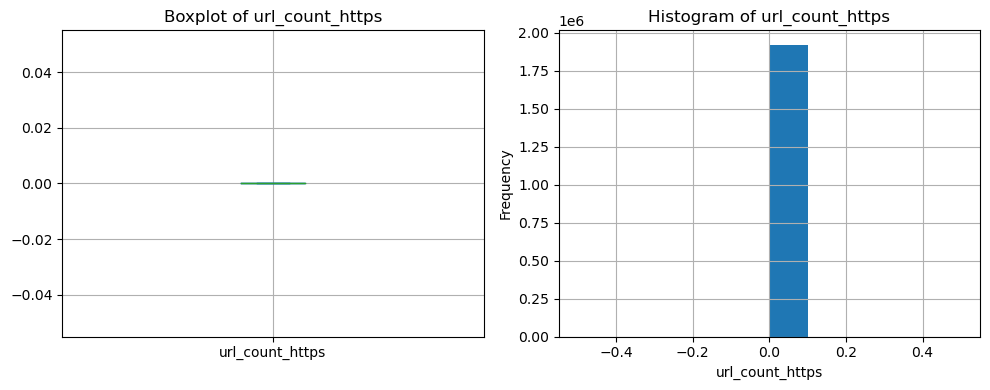

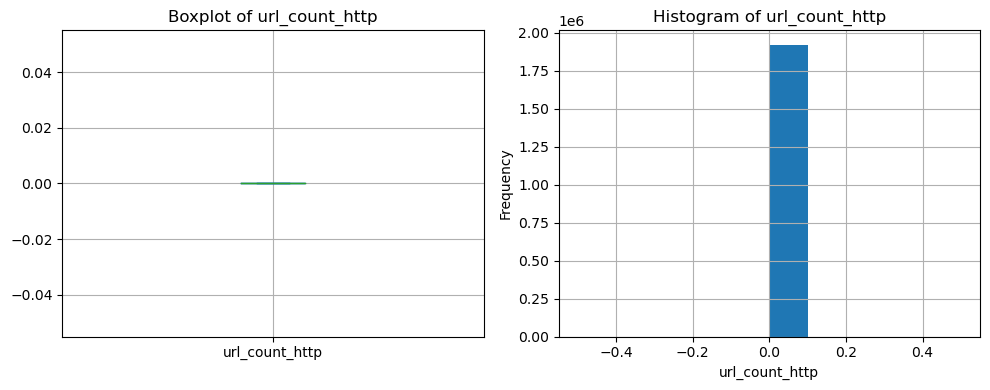

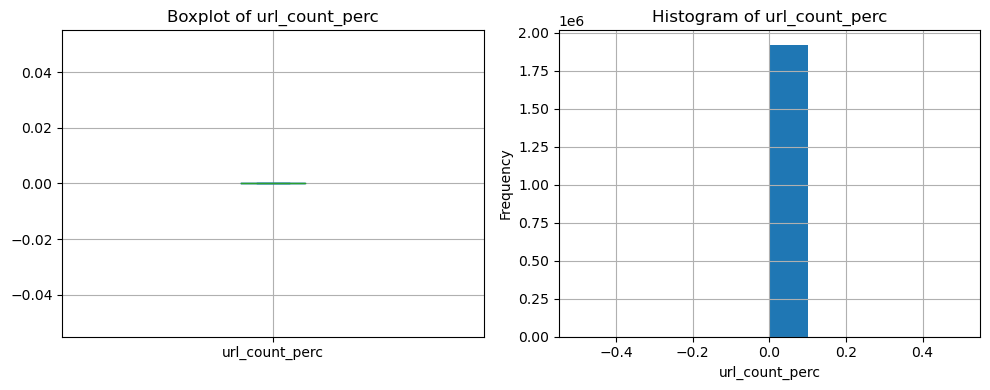

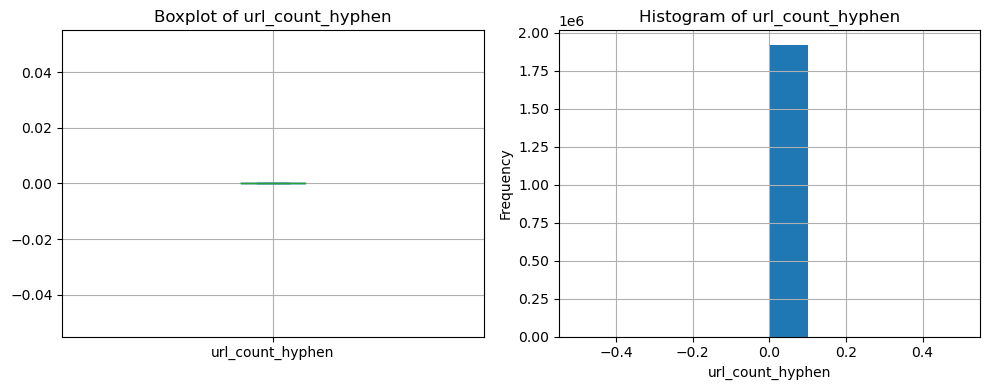

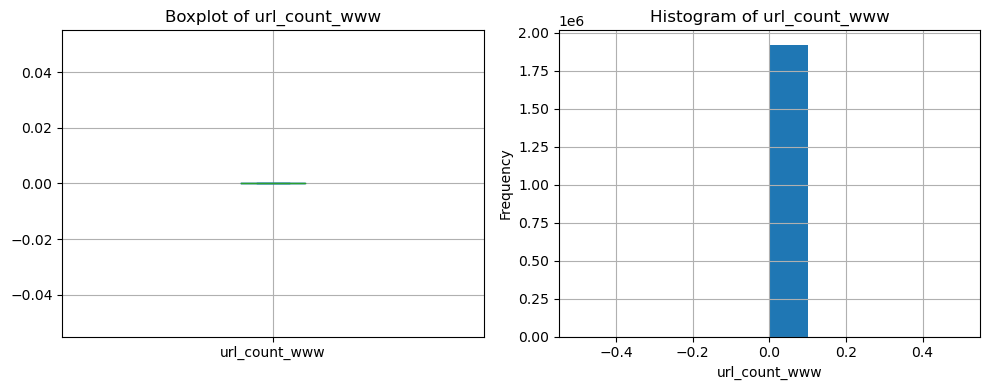

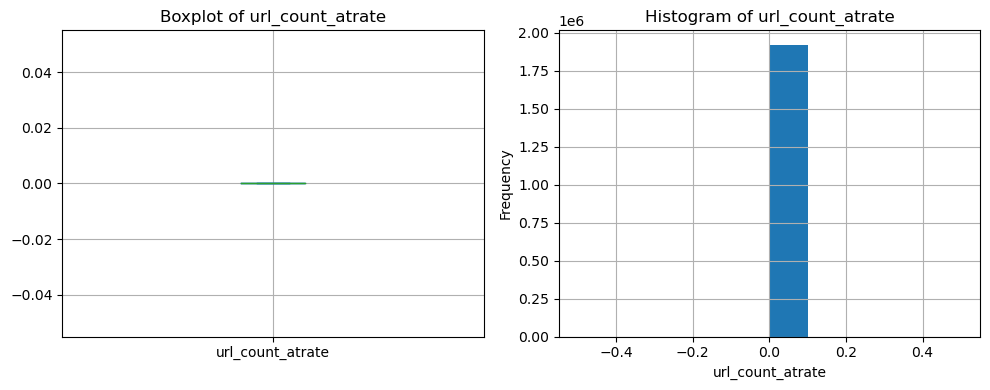

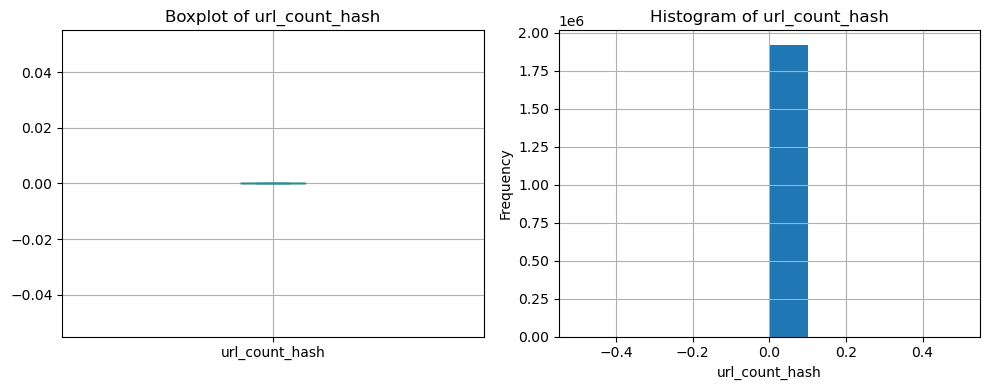

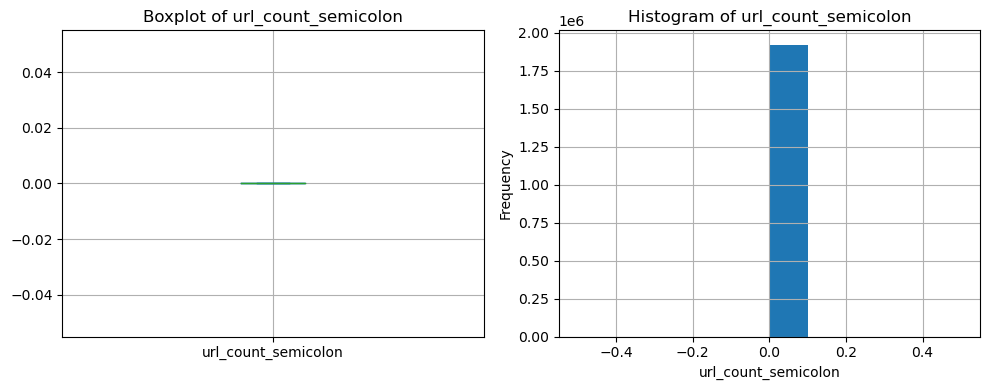

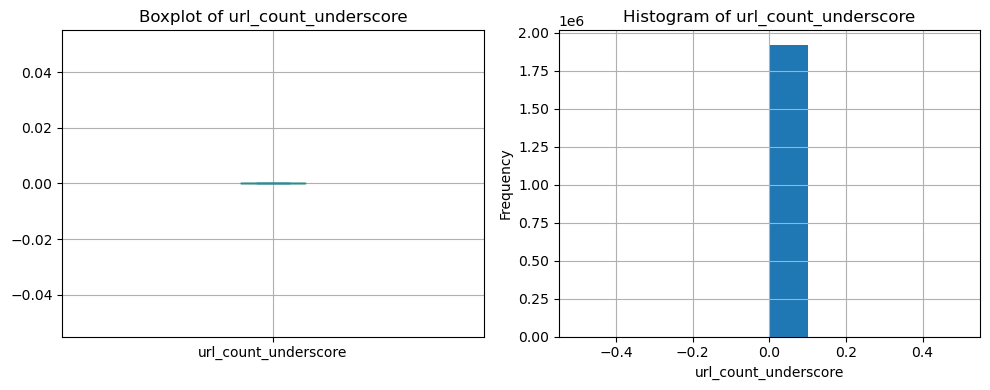

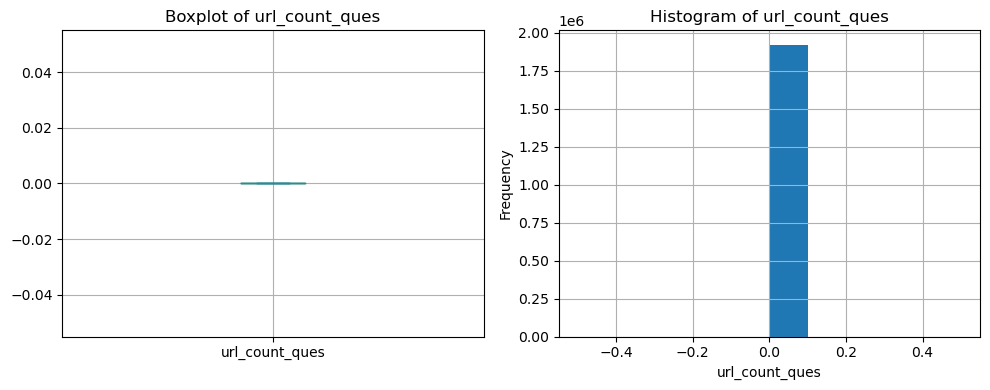

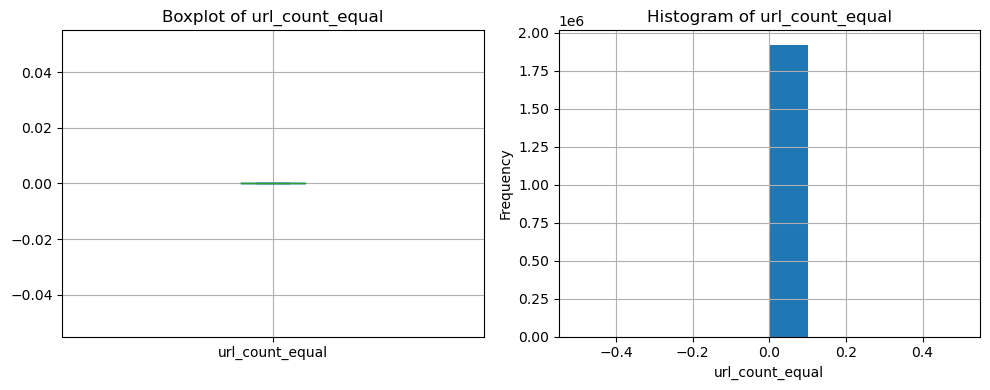

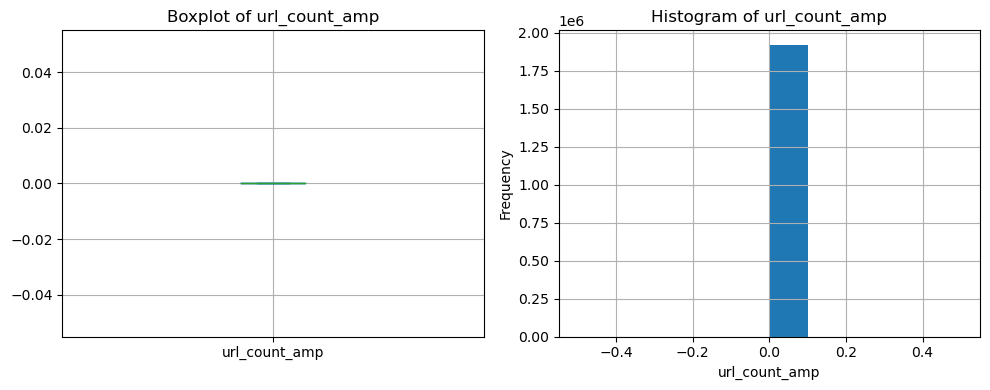

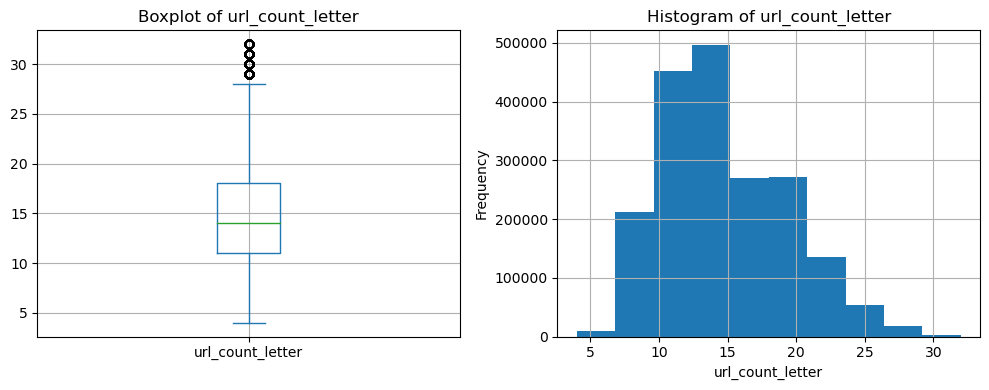

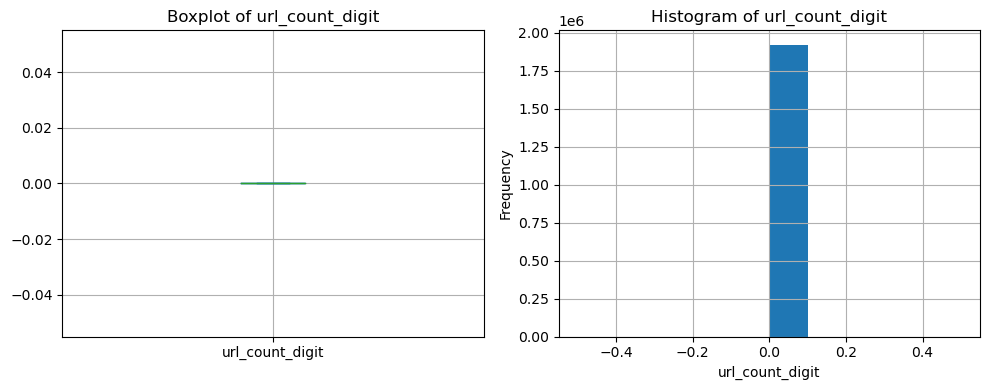

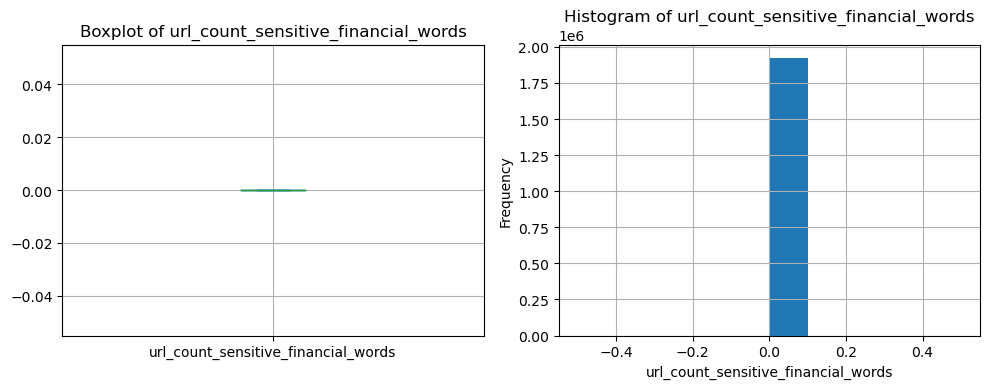

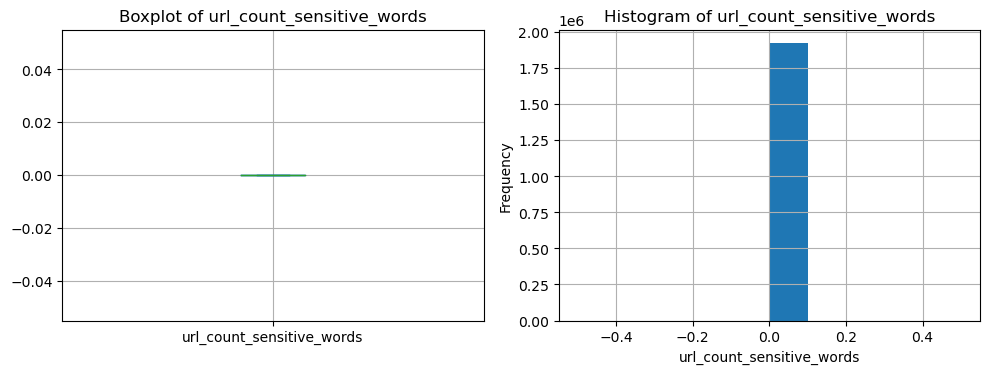

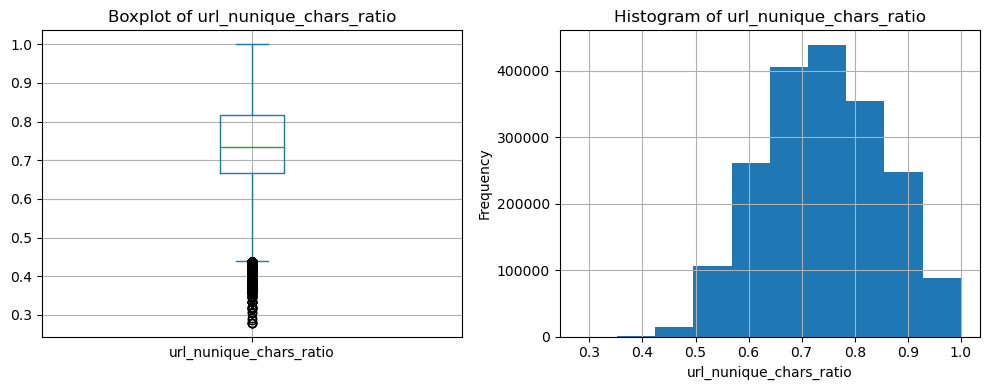

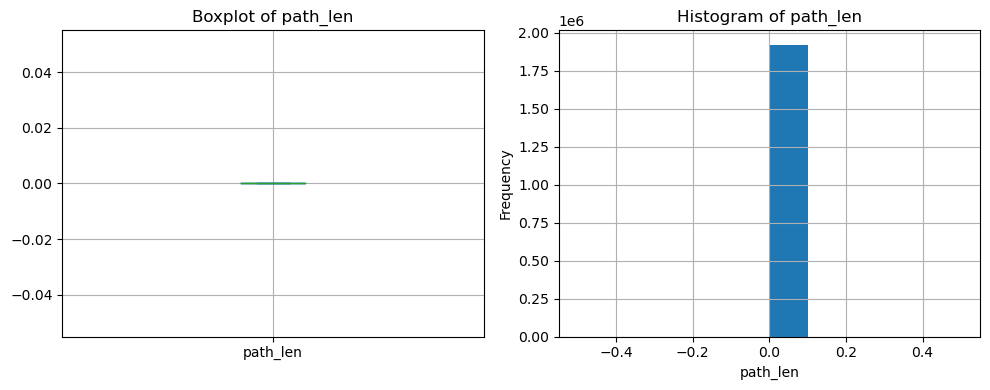

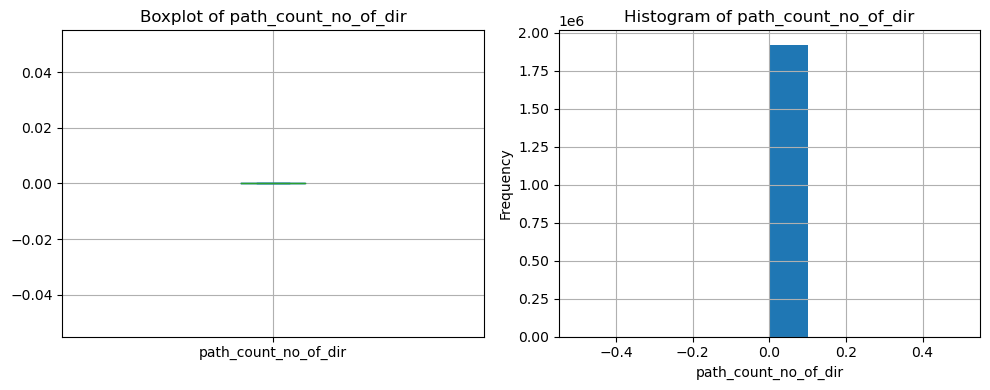

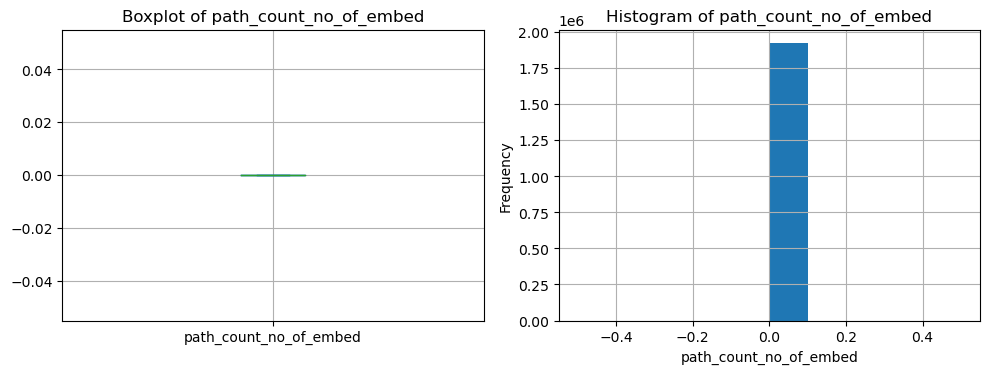

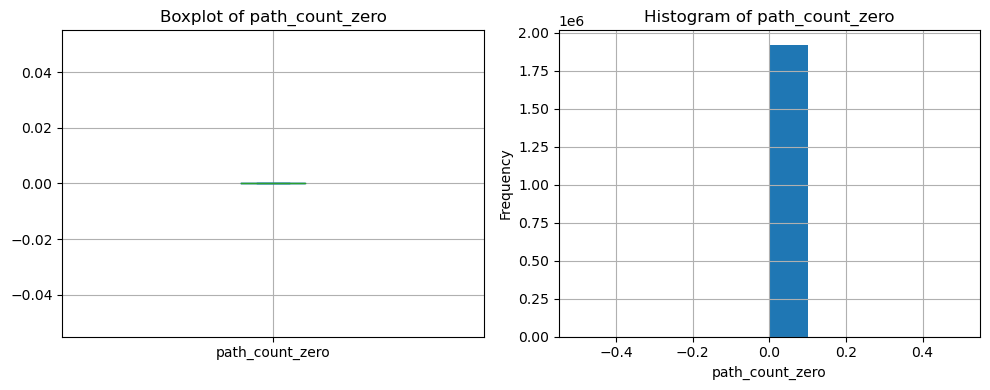

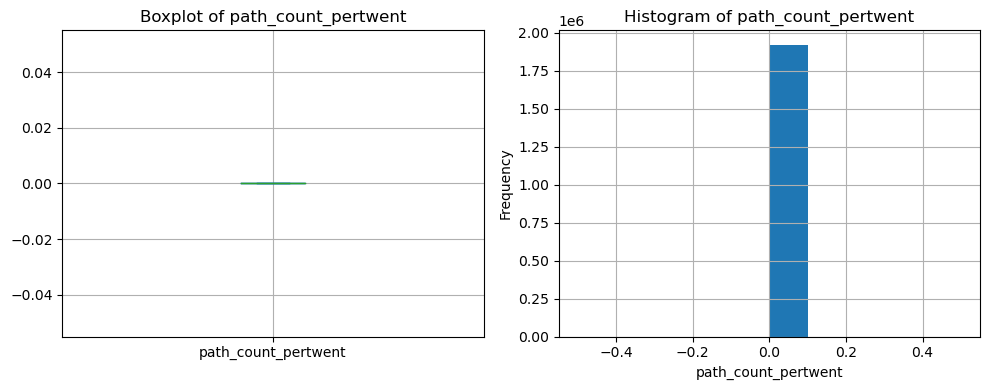

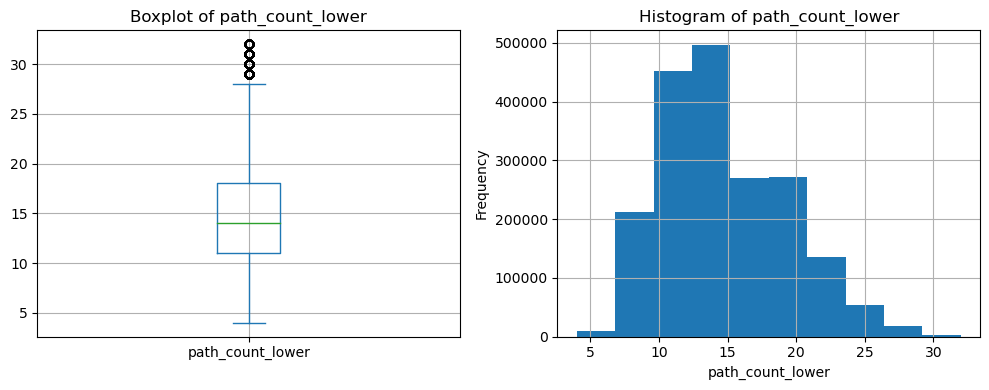

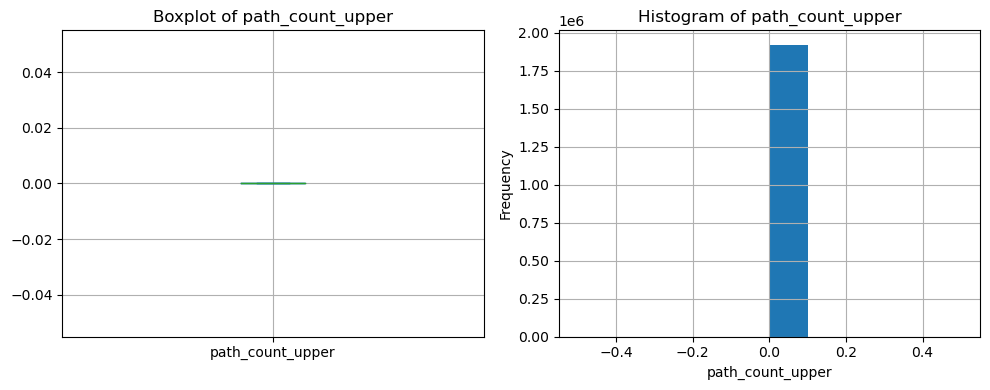

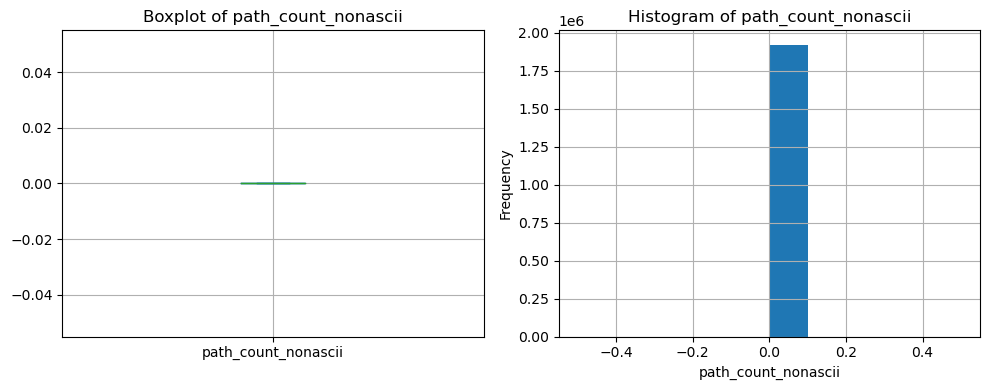

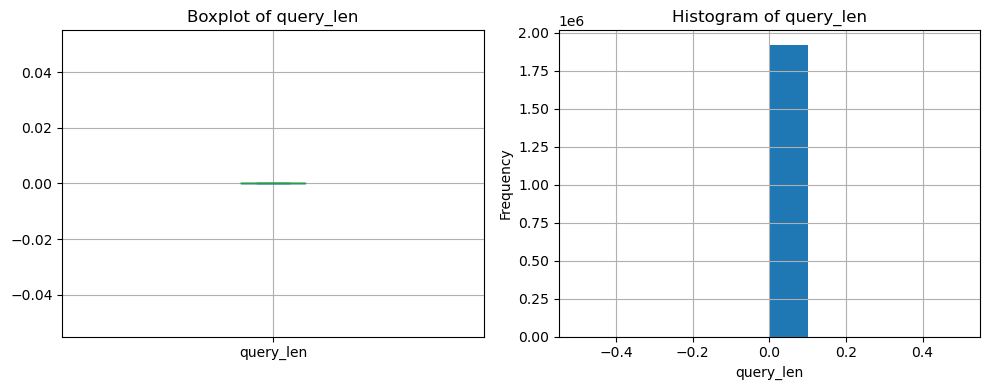

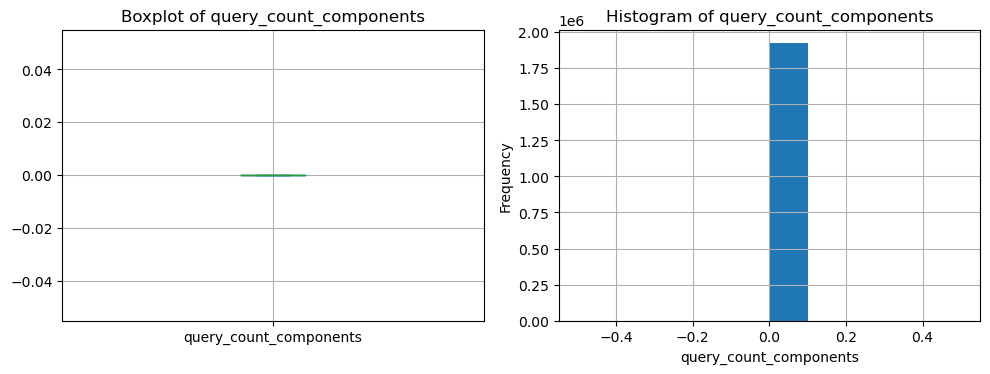

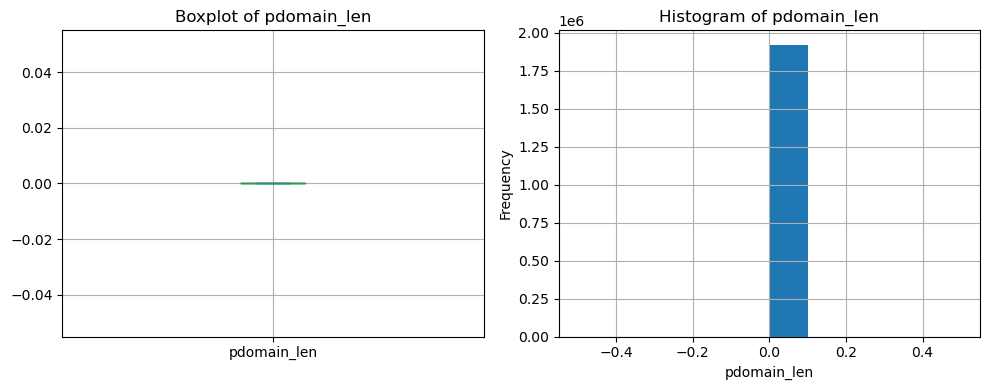

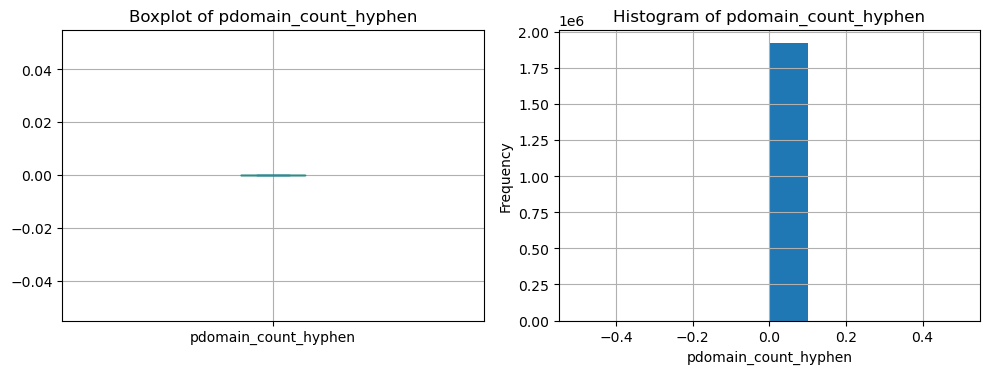

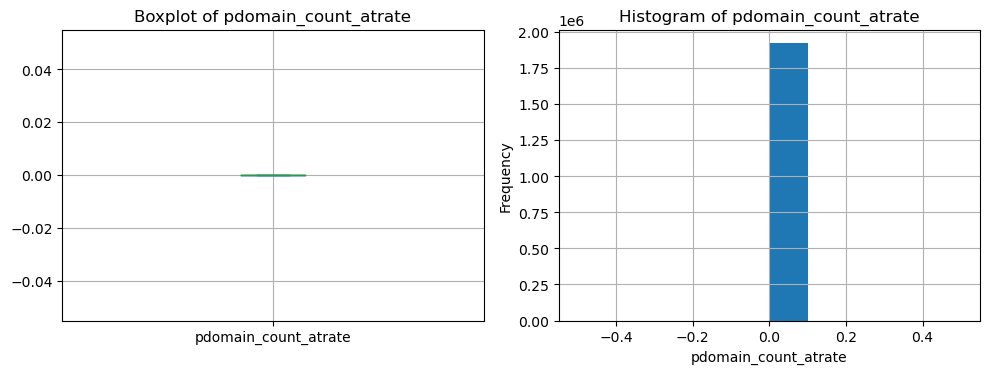

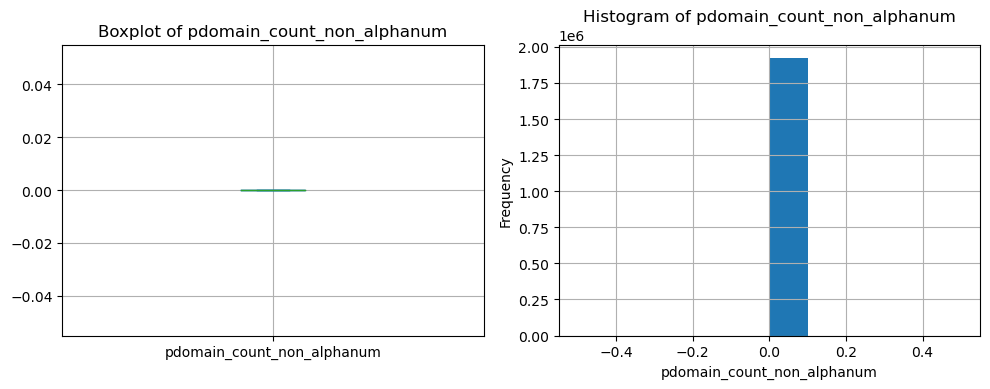

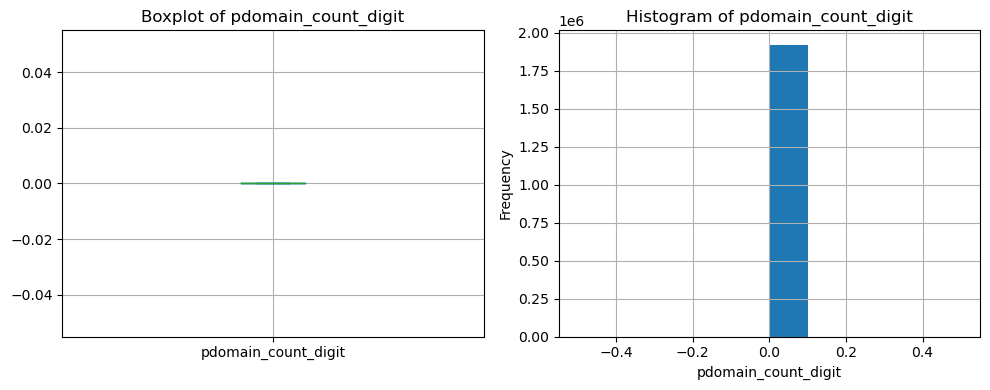

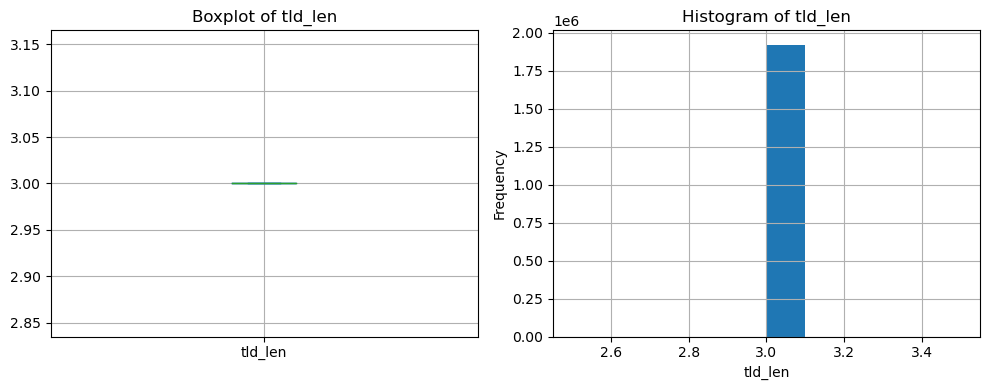

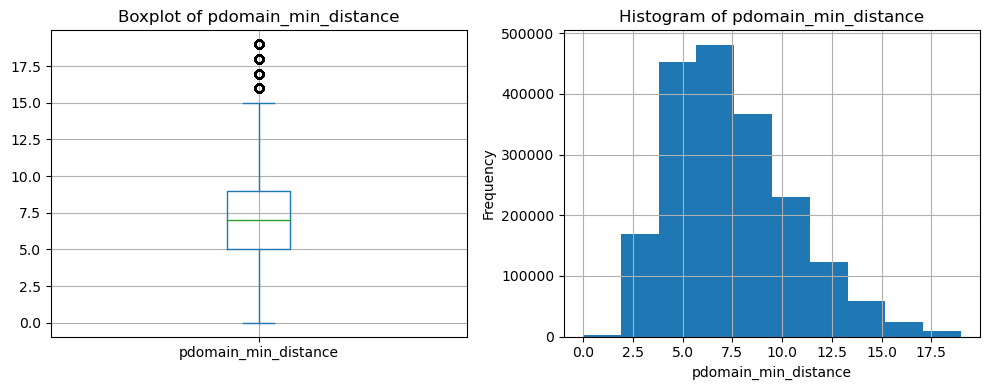

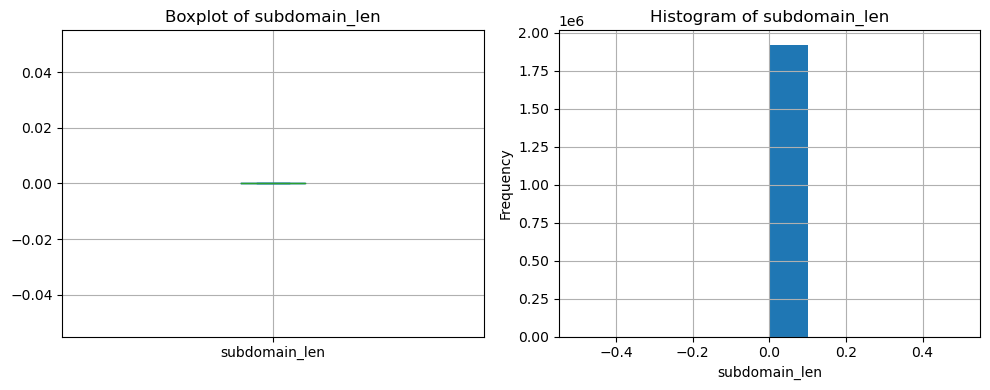

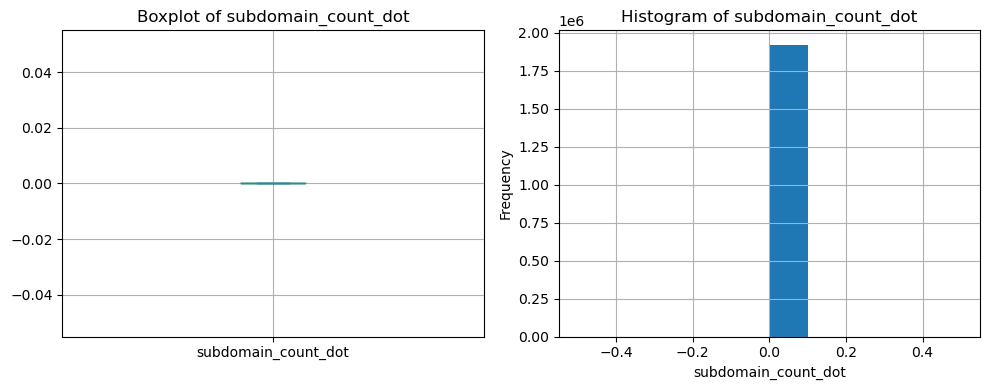

In [7]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned

url_data_no_outliers = url_data
# Remove outliers
for column in num_nonbin_features:
    url_data_no_outliers = remove_outliers_iqr(url_data_no_outliers, column)
        
# Plot new distribution
for column in num_nonbin_features:
    plt.figure(figsize=(10, 4))
    
    # Create a box plot
    plt.subplot(1, 2, 1)
    url_data_no_outliers[column].plot(kind='box')
    plt.title(f'Boxplot of {column}')
    plt.grid(True)
    
    # Create a histogram
    plt.subplot(1, 2, 2)
    url_data_no_outliers[column].plot(kind='hist')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [8]:
# Only remove outliers for certain features (see explanation above)
num_nonbin_normal_features = ["url_len", "url_entropy", "url_hamming_1", "url_hamming_00", "url_hamming_10",
                             "url_hamming_01", "url_hamming_11", "url_2bentropy", "url_3bentropy", "url_count_letter", 
                             "url_nunique_chars_ratio", "path_count_lower", "tld_len", "pdomain_min_distance"]

url_data_no_outliers = url_data
# Remove outliers
for column in num_nonbin_normal_features:
    url_data_no_outliers = remove_outliers_iqr(url_data_no_outliers, column)

#### Select relevant features and create training dataframes.
Because we have 60 features, it is necessary to select the relevant features to use in training. Below is a list of features we will use and the intuition behind its inclusion.

*url_len*: Length of the URL. Malicious URLs might be unusually long or short compared to legitimate ones.

*url_entropy*: Entropy of the URL. Higher entropy might indicate randomness, which could be a characteristic of obfuscated or malicious URLs.

*url_count_dot*: Number of dots in the URL. Excessive dots might indicate subdomains or directory traversals, common in malicious URLs.

*url_count_https* and *url_count_http*: Presence of "https" or "http" in the URL. Malicious URLs might use non-secure protocols or mimic secure ones.

*url_count_perc*: Count of percentage symbols in the URL. Used in URL encoding, which might be used to obfuscate malicious content.

*url_count_sensitive_words*: Count of sensitive words in the URL. Malicious URLs might contain keywords related to phishing, malware, or fraud.

*url_nunique_chars_ratio*: Ratio of unique characters in the URL. High uniqueness might indicate obfuscation or encoding.

*path_len*: Length of the path portion of the URL. Unusually long paths might be indicative of attempts to hide malicious content.

*path_count_no_of_dir*: Count of directories in the path. Complex directory structures might suggest obfuscation.

*path_has_any_sensitive_words*: Presence of sensitive words in the path. Malicious paths might contain keywords related to attacks.

*path_count_nonascii*: Count of non-ASCII characters in the path. Might indicate attempts to obfuscate using non-standard characters.

*pdomain_len*: Length of the parent domain. Unusually long or short domains might be indicative of malicious activity.

*pdomain_count_hyphen* and *pdomain_count_atrate*: Count of "-" and "@" symbols in the parent domain. Uncommon characters might be used in phishing URLs.

*tld*: Top-level domain. Some TLDs are more commonly associated with malicious activity.

*tld_is_sus*: Boolean indicating if the TLD is suspicious. Certain TLDs are commonly associated with malicious activity.

We then will separate the features from the labels into two different dataframes for training.

In [9]:
keep_features = ["url_len", "url_entropy", "url_count_dot", "url_count_https", "url_count_http", 
                 "url_count_perc", "url_count_sensitive_words", "url_nunique_chars_ratio", "path_len", 
                 "path_count_no_of_dir", "path_has_any_sensitive_words", "path_count_nonascii", 
                 "pdomain_len", "pdomain_count_hyphen", "pdomain_count_atrate", "tld_is_sus"]

features = url_data_no_outliers.loc[:, keep_features]
labels = url_data_no_outliers["label"]
features.head()

,url_len,url_entropy,url_count_dot,url_count_https,url_count_http,url_count_perc,url_count_sensitive_words,url_nunique_chars_ratio,path_len,path_count_no_of_dir,path_has_any_sensitive_words,path_count_nonascii,pdomain_len,pdomain_count_hyphen,pdomain_count_atrate,tld_is_sus
0,34,4.010134,1,0,0,0,0,0.558824,4,1,0,0,0,0,0,0
2,35,4.000432,3,0,0,0,0,0.514286,7,2,0,0,0,0,0,0
3,37,4.175273,2,0,0,0,0,0.540541,0,1,0,0,0,0,0,0
7,19,3.681881,1,0,0,0,0,0.736842,0,1,0,0,0,0,0,0
9,22,3.334209,1,0,0,0,0,0.545455,0,0,0,0,0,0,0,0


# Building Models

Now that we have done much of the data preprocessing, it's time to start trying different models with different hyperparameters to see which model best models this dataset.

## Decision Tree Classifier

#### Initial testing using the holdout method.

To test the efficacy of the decision tree model, we will do an initial model with the holdout method and no sampling to solve the class imbalance.

In [10]:
# Split the data set using hold out method
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

# Train the model
tree_classifier = DecisionTreeClassifier(criterion='entropy')
tree_classifier = tree_classifier.fit(features_train, labels_train)
labels_predicted = tree_classifier.predict(features_test)

print('Test accuracy:', (accuracy_score(labels_test, labels_predicted)))

Test accuracy: 0.8941710933447801


#### Nested cross validation to tune hyperparameters.

With a relatively high accuracy using a decision tree with no hyperparameter tuning and no sampling to solve the class imbalance, a decision tree seems like an effective model to pursue.

Let's grid search through hyperparameters using nested cross validation to tune the hyperparameters.

The hyperparameters we would like to tune are described below:

*max_depth*: To prevent overfitting, we will fix a max depth the tree is allowed to reach. Because there are a lot of features and values they can take on, we will decide between a max depth of 20 and 25.

*max_features*: To prevent overfitting, we will fix the maximum amount of features the tree is allowed to use. Because we have 16 features we will decide between a max features of 14 and 16.

In [12]:
tree_classifier = DecisionTreeClassifier()
tree_params = {
    "max_depth": [20, 25], 
    "max_features": [14, 16],
}

tree_grid_search = GridSearchCV(tree_classifier, tree_params, cv=5, scoring='accuracy')
tree_grid_search.fit(features, labels)

print("Best parameters:", tree_grid_search.best_params_)

fold_accuracies = cross_val_score(tree_grid_search.best_estimator_, features, labels, cv=5)
print("Accuracy:", fold_accuracies.mean())

labels_predicted = cross_val_predict(tree_grid_search.best_estimator_, features, labels, cv=5)
print("Confusion Matrix: \n", confusion_matrix(labels, labels_predicted))
print("Classification Report: \n", classification_report(labels, labels_predicted))

Best parameters: {'max_depth': 20, 'max_features': 16}
Accuracy: 0.8980021559914574
Confusion Matrix: 
 [[3104279  101948]
 [ 297305  410237]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94   3206227
           1       0.80      0.58      0.67    707542

    accuracy                           0.90   3913769
   macro avg       0.86      0.77      0.81   3913769
weighted avg       0.89      0.90      0.89   3913769



The ideal max depth and max features are 20 and 16 respectively.

With these hyperparameters, we achieve a cross validation average accuracy of 0.898. However, our recall is 0.58, meaning we only classify 58% of the malicious URLs as malicious URLs. This may be because our dataset has relatively few records of the minority label, making it harder for the decision tree to learn how to identify malicious URLs.

This is concerning as the cost of a false negative is quite high. Let us improve our model by solving the class imbalance.

#### Using SMOTE to solve the class imbalance.

To see if solving the class imbalance will improve the performance of the model, we will add SMOTE to the pipeline.

In [15]:
smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=3)

tree_classifier = DecisionTreeClassifier()
tree_params = {
    "decisiontreeclassifier__max_depth": [20, 25], 
    "decisiontreeclassifier__max_features": [14, 16]
}

pipeline = make_pipeline(smote, tree_classifier)

tree_grid_search_oversample = GridSearchCV(pipeline, tree_params, cv=5, scoring='accuracy')

tree_grid_search_oversample.fit(features, labels)

print("Best parameters:", tree_grid_search_oversample.best_params_)

fold_accuracies = cross_val_score(tree_grid_search_oversample.best_estimator_, features, labels, cv=5)
print("Accuracy:", fold_accuracies.mean())

labels_predicted = cross_val_predict(tree_grid_search_oversample.best_estimator_, features, labels, cv=5)
print("Confusion Matrix: \n", confusion_matrix(labels, labels_predicted))
print("Classification Report: \n", classification_report(labels, labels_predicted))

Best parameters: {'decisiontreeclassifier__max_depth': 25, 'decisiontreeclassifier__max_features': 16}
Accuracy: 0.8709573815758661
Confusion Matrix: 
 [[2909785  296442]
 [ 208541  499001]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92   3206227
           1       0.63      0.71      0.66    707542

    accuracy                           0.87   3913769
   macro avg       0.78      0.81      0.79   3913769
weighted avg       0.88      0.87      0.87   3913769



When using SMOTE, our accuracy decreased from 0.90 to 0.87, which is to be expected as we have more of the minority class represented in the dataset, so we are going to make more inaccurate predictions by volume. However, because we are prioritizing eliminating false negatives, we should evaluate our model using the recall (what percentage of the positive records did our model classify as positive). The recall improved from 0.58 to 0.71 after using SMOTE. Thus, oversampling the minority class improved our model's performance.

## Neural Network Classifier

#### Prepare the data and define the network architecture.


Using sklearn we created a pipeline to scale the data and train a multilayer perceptron.

In [20]:
def run_nn(layer_size, activation):
    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    scaler = StandardScaler()
    mlp = MLPClassifier(hidden_layer_sizes=layer_size, activation=activation)

    pipeline = Pipeline([('scaler', scaler), ('MLP', mlp)])

    fold_accuracies = cross_val_score(pipeline, features, labels, cv=5)
    print(f"For layer size {layer_size} and activation {activation}")
    print("Accuracy:", fold_accuracies.mean())
    print()

#### Testing the neural net model as a proof of concept.

Before we try to find the optimal hyperparameters, we would like a demonstration of the efficacy of the neural net as a model for this dataset. We will create a neural network with 10 units in the layers and a ReLU activation function. 

Using an untuned model with no oversampling correction, we achieve a relatively high accuracy, so let's pursue a neural network as a model!

In [21]:
run_nn(10, "relu")
run_nn(10, "tanh")
run_nn(10, "logistic")

For layer size 10 and activation relu
Accuracy: 0.8885360888713713

For layer size 10 and activation tanh
Accuracy: 0.8891935111705027

For layer size 10 and activation logistic
Accuracy: 0.8892047538563237



#### Picking a layer size and an activation function.

Becuase the neural net takes so long to train, we do not have the computational power to conduct a grid search to find the optimal layer sizes and activation functions for this dataset.

Thus, moving forward we will go with one activation function and one layer size.

Based on the proof of concept results, the logistic activation functions and tanh activation functions had the highest accuracy. The difference is negligible, so we will use tanh as our activation function moving forward. Additionally, we prefer tanh as our activation for this problem because it allows for more expressive modelling of the classification function. We have extremely varied feature values (as demonstrated in our data exploration) so a more expressive classification function is necessary.

We will now test different layer sizes.

In [22]:
run_nn(15, "tanh")
run_nn(20, "tanh")

For layer size 15 and activation tanh
Accuracy: 0.8915886448717814

For layer size 20 and activation tanh
Accuracy: 0.8927632161716567



Increasing the layer size from 10 to 15 or 20 did improve the accuracy. 

Because there is a negligible difference between layer size 15 and 20, for the sake of time efficiency with training, we will move forward with layer size 15.

#### Reduce runtime by using PCA.

The neural net takes a while to run, so we use PCA to reduce the number of input units, and thus, the number of weights connecting the input units to the first hidden layer, reducing the complexity of the model. We hope that this will decrease the runtime without affecting the accuracy of the model.

In [26]:
def run_nn_pca(layer_size, activation):
    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    scaler = StandardScaler()
    pca = PCA()
    mlp = MLPClassifier(hidden_layer_sizes=layer_size, activation=activation)

    pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('MLP', mlp)])

    fold_accuracies = cross_val_score(pipeline, features, labels, cv=5)
    print(f"For layer size {layer_size} and activation {activation} with PCA")
    print("Accuracy:", fold_accuracies.mean())
    
    labels_predicted = cross_val_predict(pipeline, features, labels, cv=5)
    print("Confusion Matrix: \n", confusion_matrix(labels, labels_predicted))
    print("Classification Report: \n", classification_report(labels, labels_predicted))
    print()

In [27]:
run_nn_pca(15, "tanh")

For layer size 15 and activation tanh with PCA
Accuracy: 0.8910760957584346
Confusion Matrix: 
 [[3095076  111151]
 [ 313979  393563]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94   3206227
           1       0.78      0.56      0.65    707542

    accuracy                           0.89   3913769
   macro avg       0.84      0.76      0.79   3913769
weighted avg       0.88      0.89      0.88   3913769




Given that the accuracy was not impacted much, we will use PCA to reduce the complexity of our model.

#### Using SMOTE to solve the class imbalance.

To see if solving the class imbalance will improve the performance of the model, we will add SMOTE to the pipeline.

In [30]:
def run_nn_pca_oversample(layer_size, activation):
    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=3)
    scaler = StandardScaler()
    pca = PCA()
    mlp = MLPClassifier(hidden_layer_sizes=layer_size, activation=activation)

    pipeline = make_pipeline(scaler, pca, smote, tree_classifier)

    fold_accuracies = cross_val_score(pipeline, features, labels, cv=5)
    print(f"For layer size {layer_size} and activation {activation} with PCA and SMOTE")
    print("Accuracy:", fold_accuracies.mean())

    labels_predicted = cross_val_predict(pipeline, features, labels, cv=5)
    print("Confusion Matrix: \n", confusion_matrix(labels, labels_predicted))
    print("Classification Report: \n", classification_report(labels, labels_predicted))
    print()

In [31]:
run_nn_pca_oversample(15, "tanh")

For layer size 15 and activation tanh with PCA and SMOTE
Accuracy: 0.8739986954372124
Confusion Matrix: 
 [[2940115  266112]
 [ 227049  480493]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92   3206227
           1       0.64      0.68      0.66    707542

    accuracy                           0.87   3913769
   macro avg       0.79      0.80      0.79   3913769
weighted avg       0.88      0.87      0.88   3913769




Similar to when we introduced SMOTE to the decision tree model, the accuracy decreased (from 0.89 to 0.87) because we now have more of the minority class.

However, again, we should evaluate the model based on the recall as we prioritize minimizing false negatives. Introducing SMOTE to the pipeline increased the recall from 0.56 to 0.68. This means the model classified 68% of the malicious URLs in the test set as malicious.

## Clustering

One type of machine learning algorithm that we thought might be helpful when modeling this dataset was clustering. We imagine that, if we choose the right clustering algorithm and tune the model correctly, we might see some distinct clusters of datapoints. Maybe there will be two clusters: one for benign URLs and another for malicious URLs. Perhaps we will find even more clusters that separate malicious URLs into categories that explain why they are malicious, such as URLs that pretend to be a different company's website, URLs that are likely to be associated with scams, etc. With these potential outcomes in mind, we will see if we can create an effective model using clustering.

In [12]:
# imports
from sklearn.model_selection import cross_val_score
import random
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet
from scipy.cluster import hierarchy
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

First, I need to separate the labels and their features. 

In [13]:
# identifying labels and their features
labels = url_data_no_outliers['label']
features_raw = url_data_train
features_raw.head()

,url_len,url_entropy,url_count_dot,url_count_https,url_count_http,url_count_perc,url_count_sensitive_words,url_nunique_chars_ratio,path_len,path_count_no_of_dir,path_has_any_sensitive_words,path_count_nonascii,pdomain_len,pdomain_count_hyphen,pdomain_count_atrate,tld,tld_is_sus
0,34,4.010134,1,0,0,0,0,0.558824,4,1,0,0,0,0,0,com,0
2,35,4.000432,3,0,0,0,0,0.514286,7,2,0,0,0,0,0,com,0
3,37,4.175273,2,0,0,0,0,0.540541,0,1,0,0,0,0,0,com,0
7,19,3.681881,1,0,0,0,0,0.736842,0,1,0,0,0,0,0,com,0
9,22,3.334209,1,0,0,0,0,0.545455,0,0,0,0,0,0,0,org,0


I am also dropping the 'tld,' or top-level domain, feature from the dataframe. Top-level domains are things like "com," "net," and "org" at the end of basic URLs. Because there are so many different top-level domains in this dataset, one-hot encoding the 'tld' feature introduces too many dimensions into this dataset, and PCA hardly alleviates this issue. Therefore, I will drop it from my dataset to avoid the curse of dimensionality. Luckily, the 'tld_is_sus' feature will allow me to continue to use some information about the top-level domain.

In [14]:
# removing 'tld' feature
features_wo_tld = features_raw.drop('tld', axis=1)
features_wo_tld.head()

,url_len,url_entropy,url_count_dot,url_count_https,url_count_http,url_count_perc,url_count_sensitive_words,url_nunique_chars_ratio,path_len,path_count_no_of_dir,path_has_any_sensitive_words,path_count_nonascii,pdomain_len,pdomain_count_hyphen,pdomain_count_atrate,tld_is_sus
0,34,4.010134,1,0,0,0,0,0.558824,4,1,0,0,0,0,0,0
2,35,4.000432,3,0,0,0,0,0.514286,7,2,0,0,0,0,0,0
3,37,4.175273,2,0,0,0,0,0.540541,0,1,0,0,0,0,0,0
7,19,3.681881,1,0,0,0,0,0.736842,0,1,0,0,0,0,0,0
9,22,3.334209,1,0,0,0,0,0.545455,0,0,0,0,0,0,0,0


Since there is a significant class imbalance in this dataset, I am going to apply the synthetic minority oversampling technique, or SMOTE.

In [15]:
sm = SMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=5,
)
print("Before oversampling")
print("# of class 0 samples:", sum(labels == 0))
print("# of class 1 samples:", sum(labels == 1))

oversample_features, labels = sm.fit_resample(features_wo_tld, labels)

print("\nAfter oversampling")
print("# of class 0 samples:", sum(labels == 0))
print("# of class 1 samples:", sum(labels == 1))

Before oversampling
# of class 0 samples: 3206227
# of class 1 samples: 707542

After oversampling
# of class 0 samples: 3206227
# of class 1 samples: 3206227


Next, I need to scale all data and apply dimensionality reduction to it.

In [16]:
# scaling data
std_scl = StandardScaler()
scaled_features = std_scl.fit_transform(oversample_features)

# pca
pca = PCA(n_components=0.95, svd_solver='full')
reduced_features = pca.fit_transform(scaled_features)

# showing head
features = pd.DataFrame(reduced_features)
features.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.184055,0.218846,-0.651508,-0.000386,0.696846,-0.043077,-0.519414,0.108486,0.162480,-0.002826,-0.565471
1,2.767711,0.538446,-1.389773,-0.009414,-0.016933,-0.033061,-0.526379,0.456887,-0.001303,0.006401,0.792942
2,1.607748,0.323001,-0.873320,-0.003261,-0.306093,-0.026525,-0.368480,1.142816,-0.217383,0.001423,-0.958024
3,-0.781282,0.020898,-0.079728,-0.000361,0.459299,-0.001797,-0.255223,-0.170099,-0.303038,0.000584,-0.620723
4,-0.800882,0.014052,-0.060772,-0.000333,0.022619,-0.031543,-0.112288,0.553989,1.308194,-0.003185,-0.212098


After that, I want to see what my data looks like when it is projected down to 2 dimensions. I am using different colors for benign URLs and malicious URLs.

/Users/megansickler/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


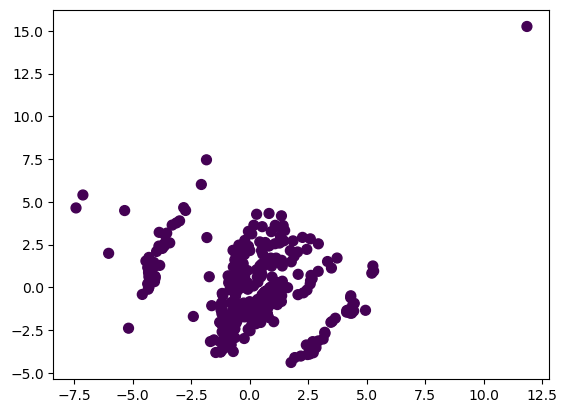

In [17]:
# plotting function provided by Angie in HW5
def scatter(data, labels, numPoints = 300):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

    
# plotting data
scatter(features, labels)

Now, I understand my data better, and it is ready for different types of clustering.

### K-means

The first clustering algorithm I will try is K-means, which will assign each point to a clusters based on which cluster has the closest centroid. The number of clusters must be explicitly specified, so I will test numbers from 2 to 10.

Because K-means requires so many distance calculations, our dataset is much too large for it. For that reason, I am using sci-kit learn's 'resample' method to randomly sample a smaller amount of data.

the best k value for this sample is  2
the average silhouette score for that k value is  0.5417282022637061


/Users/megansickler/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


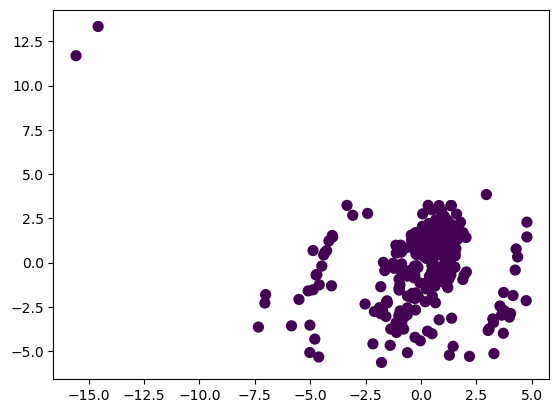

In [18]:
# sampling
NUM_SAMPLED = 1000
labels_sample, features_sample = resample(labels, features, replace=False, n_samples=NUM_SAMPLED)

# testing different k's
best_k = -1
best_avg_sil_score = -1

for k in range(2, 10):
    
    sil_score_total = 0
    
    # running several times to alleviate any initialization effects
    for i in range(100):
        kmeans = KMeans(n_clusters=k, n_init='auto')
        predicted_clusters = kmeans.fit_predict(features_sample)
        sil_score = silhouette_score(features_sample, predicted_clusters)
        sil_score_total = sil_score_total + sil_score
    
    # updating best k value
    avg_sil_score = sil_score_total / 100
    if avg_sil_score > best_avg_sil_score:
        best_avg_sil_score = avg_sil_score
        best_k = k

# using best k value for final K-means model
print("the best k value for this sample is ", best_k)
print("the average silhouette score for that k value is ", best_avg_sil_score)
kmeans = KMeans(n_clusters=best_k, n_init='auto')
predicted_clusters = pd.Series(kmeans.fit_predict(features_sample))
scatter(features_sample, predicted_clusters)

In the plot above, you can see the number of clusters found in the sampling of the dataset. The number of clusters is not totally consistent over different samples; it seems to range from 2 to 4 and is 2 most often. This suggests that there are at least 2 consistent clusters within our dataset and that a 3rd and 4th may emerge if the right sample of data is chosen.

Notably, the silhouette score is around 0.45 each time. This indicates that the datapoints are clustered well but not perfectly.

Another thing we noticed was that outliers that were not detected using the strategy in preprocessing are considered in cluster creation and therefore skew results. In extreme cases, this results in clusters of 1.

While number of clusters, silhouette scores, and outliers are important to look at, we can also evaluate the accuracy of the clusters using the labels provided in the data. The code below organizes that information into a readable format.

In [19]:
# creating a list to see the breakdown
breakdown = []
for k in range(best_k):
    breakdown.append([0, 0])

# populating breakdown list
actual_labels = labels_sample.to_list()   
for d in range(NUM_SAMPLED):
    breakdown[predicted_clusters[d]][actual_labels[d]] = breakdown[predicted_clusters[d]][actual_labels[d]] + 1

# organizing data
for k in range(best_k):
    sum_of_cluster = breakdown[k][0] + breakdown[k][1] 
    print("\nthere are", sum_of_cluster, "datapoints in cluster", k)
    print("percent benign:", round((breakdown[k][0]/sum_of_cluster) * 100, 1))
    print("percent malicious:", round((breakdown[k][1]/sum_of_cluster) * 100, 1))


there are 999 datapoints in cluster 0
percent benign: 49.2
percent malicious: 50.8

there are 1 datapoints in cluster 1
percent benign: 0.0
percent malicious: 100.0


Looking at the breakdown of the clusters over various runs, we noticed some key patterns. First, if the data is clustered into 2 clusters (as it is the majority of the time), there is typically one cluster that has a significant majority of benign datapoints, and the other cluster has a significant majority of malicious datapoints. If there are more than 2 clusters, the benign and malicious clusters are still there, and any additional clusters tend to be malicious or neutral. This supports our hypothesis that clustering may show us benign and malicious clusters and could potentially sort the malicious URLs by features that make them malicious. Additional analysis of the datapoints would be needed to identify those common features if they exist.

Overall, K-means successfully identified 2 or more clusters within our data as we had hoped. While this is encouraging, there is also room for improvement. Our somewhat low silhouette score and issues with outliers encouraged us to look at other clustering algorithms.

### DBScan

The next clustering algorithm I will try is the density-based clustering algorithm called DBScan. This algorithm is more flexible with clusters of different shapes and sizes and is also resistant to noise and outliers.

First, I am plotting the distance from each point to its fourth-nearest neighbor to see what the ideal value of Eps is for this dataset. 

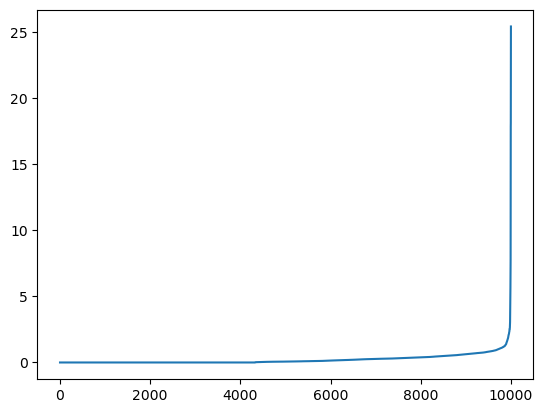

In [20]:
# sampling
NUM_SAMPLED = 10000
labels_sample, features_sample = resample(labels, features, replace=False, n_samples=NUM_SAMPLED)

# getting distances from 4th nearest neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors.fit(features_sample)
distances = neighbors.kneighbors()[0][:, 2]

# sorting and plotting
distances.sort()
plt.plot(distances)
plt.show()

After running the code above several times with several different sample sizes, it appears that the elbow of the graph lies pretty consistently around Eps 2.5. That is what I will use in DBScan, and the results are in the plot below.

/Users/megansickler/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


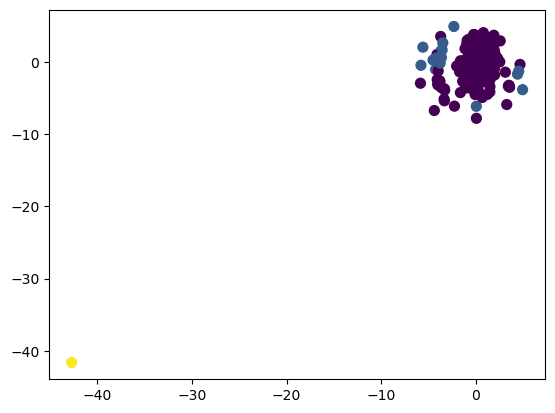

In [21]:
# sampling
NUM_SAMPLED = 100000
labels_sample, features_sample = resample(labels, features, replace=False, n_samples=NUM_SAMPLED)

# clustering data
dbscan = DBSCAN(eps=2.5, min_samples=4)
predicted_clusters = pd.Series(dbscan.fit_predict(features_sample))

# plotting clusters
scatter(features_sample, predicted_clusters)

Running the above code several times, I noticed that DBScan was also inconsistent with the number of clusters it deemed to be best for the dataset, giving 2-5 visible clusters each time. It was also interesting to see that DBScan included some datapoints that look like outliers on the graph, although the 2-dimensional representation is likely making them look further from the rest of the points than they are.

To understand these results better, let's look at the cluster breakdown like we did last time:

In [22]:
# creating a list to see the breakdown
breakdown = []
for i in range(len(set(predicted_clusters))):
    breakdown.append([0, 0])

# populating breakdown list
actual_labels = labels_sample.to_list()   
for d in range(NUM_SAMPLED):
    breakdown[predicted_clusters[d]][actual_labels[d]] = breakdown[predicted_clusters[d]][actual_labels[d]] + 1

# organizing data
for k in range(len(set(predicted_clusters))):
    sum_of_cluster = breakdown[k][0] + breakdown[k][1] 
    print("\nthere are", sum_of_cluster, "datapoints in cluster", k)
    print("percent benign:", round((breakdown[k][0]/sum_of_cluster) * 100, 1))
    print("percent malicious:", round((breakdown[k][1]/sum_of_cluster) * 100, 1))


there are 92998 datapoints in cluster 0
percent benign: 51.7
percent malicious: 48.3

there are 182 datapoints in cluster 1
percent benign: 0.0
percent malicious: 100.0

there are 6550 datapoints in cluster 2
percent benign: 25.7
percent malicious: 74.3

there are 88 datapoints in cluster 3
percent benign: 15.9
percent malicious: 84.1

there are 7 datapoints in cluster 4
percent benign: 28.6
percent malicious: 71.4

there are 47 datapoints in cluster 5
percent benign: 0.0
percent malicious: 100.0

there are 11 datapoints in cluster 6
percent benign: 0.0
percent malicious: 100.0

there are 15 datapoints in cluster 7
percent benign: 0.0
percent malicious: 100.0

there are 26 datapoints in cluster 8
percent benign: 23.1
percent malicious: 76.9

there are 30 datapoints in cluster 9
percent benign: 0.0
percent malicious: 100.0

there are 5 datapoints in cluster 10
percent benign: 0.0
percent malicious: 100.0

there are 13 datapoints in cluster 11
percent benign: 0.0
percent malicious: 100.

The cluster breakdown is surprising: it shows that there are actually a lot more clusters than are visible in our 2-dimensional scatterplot. One notable pattern is that there is typically 1 large cluster that is about half benign and half-malicious. The other, smaller ~12 clusters that emerge each time have clear malicious majorities. 

This phenomenon persists even as Eps is decreased as low as 1 and increased as much as 5. In cases where Eps is very small, the phenomemon disappears but gives way to a large number of clusters to the extent that they are no longer informative. Increasing Eps beyond 5 resulted in a dead kernel.

In conclusion, DBScan was not as good at identifying benign URLs as K-means was. It also struggled to identify the vast majority of malicious URLs, although some smaller clusters of malicious URLs suggest that DBScan might be recognizing subgroups of malicious URLs even more clearly than K-means was. Overall, K-means is a better algorithm to use on this dataset, but DBScan hints at some potentially useful information about malicious URLs.

### Hierarchical Clustering

Although there is no obvious hierarchy in this data, we also thought it would be interesting to perform hierarchical clustering to see if that revealed a hierarchy. We will perform hierarchical clustering with the following distance measures: single, complete, average, centroid, and Ward's.

In [25]:
# sampling
NUM_SAMPLED = 10000
labels_sample, features_sample = resample(labels, features, replace=False, n_samples=NUM_SAMPLED)

# getting proximity matrix
proximity_matrix = pdist(features_sample)

# creating hierarchies with different strategies using the same proximity matrix
single = hierarchy.single(proximity_matrix)
complete = hierarchy.complete(proximity_matrix)
average = hierarchy.average(proximity_matrix)
centroid = hierarchy.centroid(proximity_matrix)
ward = hierarchy.ward(proximity_matrix)

# calculating cophenetic correlation coefficients
cpcc_single = cophenet(single, proximity_matrix)
cpcc_complete = cophenet(complete, proximity_matrix)
cpcc_average = cophenet(average, proximity_matrix)
cpcc_centroid = cophenet(centroid, proximity_matrix)
cpcc_ward = cophenet(ward, proximity_matrix)

print("single: ", cpcc_single[0])
print("complete: ", cpcc_complete[0])
print("average: ", cpcc_average[0])
print("centroid: ", cpcc_centroid[0])
print("ward: ", cpcc_ward[0])

single:  0.7897484019224799
complete:  0.7672149805678448
average:  0.9083738175314262
centroid:  0.9048259647379144
ward:  0.4856621777819855


Using 'average' to measure distance was consistently the best way to perform hierarchical clustering on this dataset, barely edging out 'centroid' each time we ran the above code. For that reason, we will look at the dendrogram for hierarchical clustering using 'average' to measure distance.

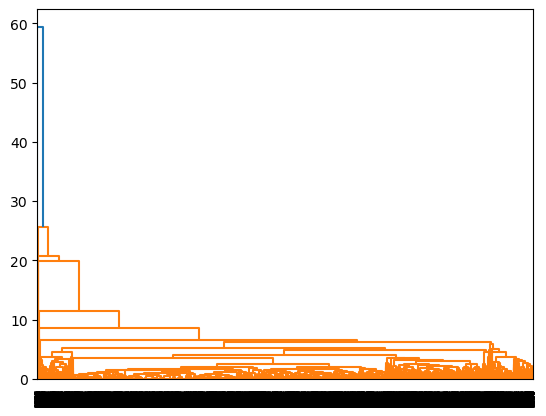

In [26]:
hierarchy.dendrogram(average)
plt.show()

The hierarchy shown above has surprisingly large vertical gaps, indicating strong clusters. It supports the other methods of clustering in showing that the ideal number of clusters is somewhere around the range 2 to 5. Let's look at the labels to see how well this data is clustered, just as we did for K-means and DBScan:

In [43]:
predicted_clusters = hierarchy.fcluster(average, t=15, criterion='distance')

# creating a list to see the breakdown
breakdown = []
for i in range(len(set(predicted_clusters))):
    breakdown.append([0, 0])

# populating breakdown list
actual_labels = labels_sample.to_list()   
for d in range(NUM_SAMPLED):
    breakdown[predicted_clusters[d]-1][actual_labels[d]] = breakdown[predicted_clusters[d]-1][actual_labels[d]] + 1

# organizing data
for k in range(len(set(predicted_clusters))):
    sum_of_cluster = breakdown[k][0] + breakdown[k][1] 
    print("\nthere are", sum_of_cluster, "datapoints in cluster", k)
    print("percent benign:", round((breakdown[k][0]/sum_of_cluster) * 100, 1))
    print("percent malicious:", round((breakdown[k][1]/sum_of_cluster) * 100, 1))


there are 3 datapoints in cluster 0
percent benign: 33.3
percent malicious: 66.7

there are 8 datapoints in cluster 1
percent benign: 0.0
percent malicious: 100.0

there are 1 datapoints in cluster 2
percent benign: 0.0
percent malicious: 100.0

there are 20 datapoints in cluster 3
percent benign: 0.0
percent malicious: 100.0

there are 9967 datapoints in cluster 4
percent benign: 49.1
percent malicious: 50.9

there are 1 datapoints in cluster 5
percent benign: 0.0
percent malicious: 100.0


Interestingly, this showed the same phenomenon that appeared during DBScan: there is one giant cluster that is about half and half, and several smaller clusters that are strongly skewed toward the malicious URLs. This hierarchical clustering did not tell us much about what might be causing a hierarchy in URL data, but it did support the idea of several malicious URL clusters, which K-means and DBScan hinted at.

### Conclusion

Clustering was an interesting way to see that certain URLs are related to each other more than others. All three clustering algorithms that we tried showed us that there are likely some strong subcategories under the general category of malicious URLs. However, K-means was clearly the best algorithm to use if you are trying to predict future outcomes using clustering.

# Comparing Models